In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
# cd /gdrive/MyDrive/4th Sem/Thesis/Hindi Hostility Detection/Notebooks/IndicBert Model

In [3]:
pwd

'/home/mohit19014/Hostility Detection/Final Experiments/HindiBERT/4LSTM + 4MHA'

In [4]:
cd /home/mohit19014/Hostility Detection/

/home/mohit19014/Hostility Detection


In [5]:
ls

 ASL/    Data/   'Final Experiments'/   Photos/
 Code/   Dumps/   Models/               Tensorboard/


In [6]:
!nvidia-smi

Sat Apr 17 11:36:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   59C    P0   206W / 250W |   8379MiB / 16160MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Installing Required Libraries

In [7]:
# pip install torchsummary -q

In [8]:
# pip install fasttext

In [9]:
# pip install gensim

In [10]:
# pip install transformers -q

In [11]:
# pip install sentencepiece -q

####Importing Libraries

In [12]:
### General
import re
import copy
import string
import pickle
import numpy as np
import pandas as pd
import fasttext
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

### Sklearn
import joblib
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

### Transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup


### ASL
from ASL.src.loss_functions.losses import AsymmetricLoss

#### Configuration Class


In [13]:
class Config1:
    def __init__(self):
        super(Config1, self).__init__()

        self.SEED       = 42
#         self.MODEL_PATH = 'Models/IndicBert'#'ai4bharat/indic-bert'
#         self.MODEL_PATH = 'Models/IndicBert'
#         self.MODEL_PATH = 'monsoon-nlp/hindi-bert'
        self.MODEL_PATH = 'Data/Pretrained/HindiBERT/Checkpoint 2500/'



        # data
        self.PERCENTAGE_DATA  = 10
        self.TOKENIZER        = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH       = 128
        self.BATCH_SIZE       = 16
        self.VALIDATION_SPLIT = 0.10
        self.PREPROCESS_INPUT = False

        # Coarse-grained or Fine-Grained
        self.NUM_LABELS           = 4                                        ### 1:CG   2:Combine    4:FG
        self.COARSE_GRAINED       = True if self.NUM_LABELS ==1 else False 
        self.COARSE_GRAINED_CLASS = 'Hostile'                                ### 'Fake' 'Defamation' 'Hate' or 'Offensive' 
        
        # Combining Hostile Dimensions
        self.COMBINE_HATE_OFFENSIVE  = False     #True if self.NUM_LABELS ==2 else False
        self.COMBINE_DEFAMATION_FAKE = False     #if self.NUM_LABELS ==2 else False


        ###Features to include
        self.SUPERVISED_LEXICON_ATTENTION = True
        self.HOSTILITY_LEXICON            = True
        self.LEXICON_AVERAGE              = False
        self.EMOJI_INFO                   = True
        self.EMBED_EMOJI                  = False    ### Doesnot do preprocessing, just adds emoji text into the post
        self.HASHTAG_INFO                 = True
        self.EMOJI_FLAG                   = " with Emoji"       ### "" or " without Emoji" or " with Emoji" --> space at beginning
        self.TOKENIZER_FLAG               = "Sentence Piece"
        self.PREPROCESSING_FLAG           = "Raw Text"
        
        ### Lexicon Parameters
        self.PAD_LENGTH = 128   ### Makes Sequence Length, Lexicon Vector, and gold attention vector 
        

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.NUMBER_OF_BERT_LAYERS = 1
        self.FULL_FINETUNING = True
        self.LR = 0.001
        self.OPTIMIZER = 'AdamW'
        self.OUTPUT_HIDDEN_STATE=True
        self.OUTPUT_ATTENTIONS = True
        self.EPOCHS = 50

        
        ### Loss Hyperparameters
        self.DEFAMATION_LOSS_LAMBDA = 1.0
        self.FAKE_LOSS_LAMBDA       = 1.0
        self.HATE_LOSS_LAMBDA       = 1.0
        self.OFFENSIVE_LOSS_LAMBDA  = 1.0

        
        ### Load Checkpoint
        self.SAVE_BEST_ONLY   = True
        self.LOAD_CHECKPOINT  = False
        self.FINE_TUNE_COARSE = False
        self.CHECKPOINT_PATH  = ""
        self.MODEL_FOLDER     = "Final Experiments/HindiBERT/4LSTM + 4MHA/BCE + MSE/"

        ### Visualization
        self.VISUALIZE_EMBEDDINGS = False
        self.PLOT_LOSS = True

        ### Evaluation 
        self.THRESHOLD = 0.5
        self.SERVER    = True

config = Config1()

warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=ResourceWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
a = pickle.load(open("Data/pkl_fine_train.pkl",'rb'))
a = a.iloc[:10,:]
for col in a.columns:
    print(col)
a.head(2)

Unique ID
Post
Raw Text
Raw Text without Emoji
Raw Text with Emoji
Preprocessed
Preprocessed without Emoji
Preprocessed with Emoji
Sentence Piece Raw Text
Sentence Piece Raw Text without Emoji
Sentence Piece Raw Text with Emoji
Sentence Piece Preprocessed
Sentence Piece Preprocessed without Emoji
Sentence Piece Preprocessed with Emoji
Raw Text Lex Pad
Raw Text Lex Avg
Raw Text Mask
Raw Text DGA
Raw Text FGA
Raw Text HGA
Raw Text OGA
Raw Text without Emoji Lex Pad
Raw Text without Emoji Lex Avg
Raw Text without Emoji Mask
Raw Text without Emoji DGA
Raw Text without Emoji FGA
Raw Text without Emoji HGA
Raw Text without Emoji OGA
Raw Text with Emoji Lex Pad
Raw Text with Emoji Lex Avg
Raw Text with Emoji Mask
Raw Text with Emoji DGA
Raw Text with Emoji FGA
Raw Text with Emoji HGA
Raw Text with Emoji OGA
Preprocessed Lex Pad
Preprocessed Lex Avg
Preprocessed Mask
Preprocessed DGA
Preprocessed FGA
Preprocessed HGA
Preprocessed OGA
Preprocessed without Emoji Lex Pad
Preprocessed without Emoj

,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [15]:
a[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Mask'][0]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
a[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' DGA'][0].shape

torch.Size([128])

In [17]:
a[config.PREPROCESSING_FLAG + config.EMOJI_FLAG +' Lex Pad'][0].shape

(128, 5)

In [18]:
a[config.TOKENIZER_FLAG + " " +config.PREPROCESSING_FLAG + config.EMOJI_FLAG ][2]

"[CLS] सुश ##ांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीप ##ेश को सुश ##ांत की हत्या के दिन ही क्यों याद आई ? देखिए ' पूछता है भारत ' अर्न ##ब के साथ रिपब्लिक भारत पर # L ##IV ##E : https : / / t . co / G ##9 ##45 ##H ##v ##z ##M ##0 ##Z https : / / t . co / K ##f ##H ##7 ##x ##F ##1 ##I ##d ##M [SEP]"

<h3>Helper Functions

In [19]:
def get_texts(df):
    return df['Raw Text' + config.EMOJI_FLAG]

In [20]:
def get_processed_texts(df):
    return df['Preprocessed'+ config.EMOJI_FLAG]

In [21]:
def get_tokenized_texts(df):
    return df['Sentence Piece Raw Text' + config.EMOJI_FLAG]

In [22]:
def get_labels(df):
    if(config.COARSE_GRAINED):
        return [[float(i)] for i in df[config.COARSE_GRAINED_CLASS]]  
    
    else:
        labels = []
        for i in range(len(df)):
            label = []
            label.append(df['Defamation'][i])
            label.append(df['Fake'][i])
            label.append(df['Hate'][i])
            label.append(df['Offensive'][i])
            label = [float(i) for i in label]
            labels.append(label)
        return labels

In [23]:
def get_gold_attention_vectors(df):
    gold_attn_vectors = []
    for i in range(len(df)):
        gold_attn_vector = []
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' DGA'][i][:config.PAD_LENGTH]))
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' FGA'][i][:config.PAD_LENGTH]))
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' HGA'][i][:config.PAD_LENGTH]))
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' OGA'][i][:config.PAD_LENGTH]))
        gold_attn_vectors.append(gold_attn_vector)
    return gold_attn_vectors

In [24]:
def get_emoji_vectors(df):
    return df['Avg Emoji Vectors'].values

In [25]:
def get_hashtag_vectors(df):
    return df['Avg Hashtag Vectors']

In [26]:
def get_lexicons(df):
    if(config.LEXICON_AVERAGE):
        softmax_lex_avg = []
        for i in range(len(df)):
            softmax_lex_avg.append(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Lex Avg'][i][:config.PAD_LENGTH,:]) ### returns [len(df), 128, 4] sized array
        return softmax_lex_avg
    else:
        softmax_lex_padded = []
        for i in range(len(df)):
            softmax_lex_padded.append(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Lex Pad'][i][:config.PAD_LENGTH,:]) ### returns [len(df), 128, 4] sized array
        return softmax_lex_padded

In [27]:
def get_lexicon_masks(df):
    lex_mask = []
    for i in range(len(df)):
        lex_mask.append(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Mask'][i][:config.PAD_LENGTH]) ### returns [len(df), 128, 4] sized array
    return lex_mask

In [28]:
def get_mha_masks(df):
    mha_masks = []
    for i in range(len(df)):
        mha_mask = df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Mask'][i][:config.PAD_LENGTH] ### returns [len(df), 128, 4] sized array
        mha_mask = 1 - mha_mask
        mha_mask = mha_mask.astype(int)
        mha_masks.append(mha_mask)
    return mha_masks

In [29]:
# def get_indicft_embeddings(df):
#     indicft_vectors = []
#     for i in range(len(df)):
#         indicft_vectors.append(df['Padded IndicFT Embeddings Preprocessed '+ config.EMOJI_FLAG][i][:config.PAD_LENGTH, :])
#     return indicft_vectors

In [30]:
### Preprocessing Flag = 0 --> Raw Text 
###               Flag = 1 --> Without Emojis
###               Flag = 2 --> With Emoji

def prepocess(df,flag):
    
    for i in range(len(df)):
        text = df['Post'][i]
        
        if(flag==1):
            ## Removing Emojis
            emojis = re.compile("["      u"\U0001F600-\U0001F64F"  # emoticons
                                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                        u"\U00002500-\U00002BEF"  # chinese char
                                        u"\U00002702-\U000027B0"
                                        u"\U00002702-\U000027B0"
                                        u"\U000024C2-\U0001F251"
                                        u"\U0001f926-\U0001f937"
                                        u"\U00010000-\U0010ffff"
                                        u"\u2640-\u2642"
                                        u"\u2600-\u2B55"
                                        u"\u200d"
                                        u"\u23cf"
                                        u"\u23e9"
                                        u"\u231a"
                                        u"\ufe0f"  # dingbats
                                        u"\u3030"
                                        "]+", flags=re.UNICODE)
            text =  emojis.sub(r'', text)
            
        if(flag==2):
            text = emoji.demojize(text, delimiters=("" , " "))
            
        df.at[i,column_names[flag]] = text
        
    return df

In [31]:
def plot_tsne(embeddings,labels):

    tsne = TSNE(n_components=2, random_state=0)

    outer_cname = { '0' : {1: 'Defamation', 0:'Non-Defamation'},
                    '1' : {1: 'Fake', 0:'Non-Fake'},
                    '2' : {1: 'Hate', 0:'Non-Hate'},
                    '3' : {1: 'Offensive', 0:'Non-Offensive'},
                    '4' : {1: 'Hostile', 0:'Non-Hostile'}}

    class_mapping = {'Defamation': '0',
                     'Fake': '0',
                     'Hate': '2',
                     'Offensive': '3',
                     'Hostile': '4'}

    if(config.COARSE_GRAINED):
        transformed = tsne.fit_transform(embeddings)
        fig, ax = plt.subplots()
        for label in np.unique(labels): 
            indices = [i for i, l in enumerate(labels) if l == label]
            x = np.take(transformed[:,0], indices)
            y = np.take(transformed[:,1], indices)

            cdict = {1: 'red', 0: 'blue'}
            cname = outer_cname[class_mapping[config.COARSE_GRAINED_CLASS]]
            ax.scatter(x,y, color = cdict[label], label=cname[label])
        
        ax.legend(loc='best')
        plt.show()

    else:
        transformed = tsne.fit_transform(embeddings)
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

        
        counter = 0
        all_labels = labels      
        for row in ax:
            for col in row:
                labels  = all_labels[:,counter]
                for label in np.unique(labels): 
                    indices = [i for i, l in enumerate(labels) if l == label]
                    x = np.take(transformed[:,0], indices)
                    y = np.take(transformed[:,1], indices)

                    cdict = {1: 'red', 0: 'blue'}
                    cname = outer_cname[str(counter)]
                    col.scatter(x,y, color = cdict[label], label=cname[label], alpha =0.5)
                    col.legend(loc='best')
                counter += 1
        plt.show()

<h3>Dataset Class


In [32]:
class HindiHostilityDataset(Dataset):
    def __init__(self, dataset_path):
        super(HindiHostilityDataset, self).__init__()

        df          = pickle.load(open(dataset_path, 'rb'))
        
        if(config.COARSE_GRAINED == False and config.SERVER == True):
            df = df[df['Hostile']==1]
            df = df.reset_index(drop=True)       
        
        num_samples = int(config.PERCENTAGE_DATA*len(df)/100)
        df          = df.iloc[:num_samples,:] 
        
        print("Taking ",num_samples," only")
        if(config.PREPROCESS_INPUT):
            df = preprocess(df)

           
        self.texts             = get_texts(df)
        self.processed_texts   = get_processed_texts(df)
        self.tokenized_texts   = get_tokenized_texts(df)
        self.labels            = get_labels(df)
        self.gold_attn_vectors = get_gold_attention_vectors(df) ### Value at an index is a list four 50 dim vectors
        self.lexicon_vectors   = get_lexicons(df)               ### A vector of 50*4 size or 4 size vector
        self.lexicon_masks     = get_lexicon_masks(df)          ### A vector of size 128
        self.mha_masks         = get_mha_masks(df)
        self.emoji_vectors     = get_emoji_vectors(df)          ### A 300 dimension mean vector
        self.hashtag_vectors   = get_hashtag_vectors(df)        ### A 300 dimension mean vector

        self.max_length        = config.MAX_LENGTH
        self.tokenizer         = config.TOKENIZER
        

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        tokenized_conts = self.tokenizer.encode_plus( self.texts[index], 
                                                      max_length=self.max_length,
                                                      padding='max_length',
                                                      truncation=True,
                                                      return_attention_mask=True,
                                                      return_token_type_ids=False,
                                                      return_tensors='pt')
        
        post_input_ids       = tokenized_conts['input_ids'].squeeze()
        post_attention_masks = tokenized_conts['attention_mask'].squeeze()

#         print(type(post_attention_masks))
#         print(type(post_attention_masks[0]))

        return { 'posts': {
                          'text': self.texts[index],
                          'processed_text'   : self.processed_texts[index],
                          'tokenized_text'   : self.tokenized_texts[index],
                          'lexicon_vector'   : torch.Tensor(self.lexicon_vectors[index]),
                          'gold_attn_vectors': torch.Tensor(self.gold_attn_vectors[index]),
                          'lexicon_mask'     : torch.Tensor(self.lexicon_masks[index]).type(torch.ByteTensor),
                          'mha_mask'         : torch.Tensor(self.mha_masks[index]).type(torch.ByteTensor),
                          'emoji_vector'     : torch.Tensor(self.emoji_vectors[index]),
                          'hashtag_vector'   : torch.Tensor(self.hashtag_vectors[index]),
                          'input_ids'        : post_input_ids,
                          'attention_masks'  : post_attention_masks
                        },
                
                 'labels': torch.Tensor(self.labels[index])#.float()
                }


<h4> Checking Dataset and DataLoaders

In [33]:
torch.manual_seed(config.SEED)

train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")


Taking  267  only
Taking  37  only
Taking  78  only


In [34]:
a = train_dataset[0]
print(a['labels'].shape)
print(a['posts']['attention_masks'].shape)
print(a['posts']['input_ids'].shape)
print(a['posts']['gold_attn_vectors'].shape)

print(a['posts']['lexicon_vector'].shape)
print(a['posts']['lexicon_mask'].shape)
print(a['posts']['mha_mask'].shape)


print(a['posts']['emoji_vector'].shape)
print(a['posts']['hashtag_vector'].shape)


print(type(a['posts']['gold_attn_vectors']))
print(type(a['posts']['lexicon_vector']))
print(type(a['posts']['emoji_vector']))


torch.Size([4])
torch.Size([128])
torch.Size([128])
torch.Size([4, 128])
torch.Size([128, 5])
torch.Size([128])
torch.Size([128])
torch.Size([300])
torch.Size([300])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [35]:
# print(a['posts']['processed_text'])
print(a['posts']['tokenized_text'])

[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है f ##old ##ed _ h ##ands जय श्री राम f ##old ##ed _ h ##ands [SEP]


In [36]:
print(config.TOKENIZER.convert_ids_to_tokens(a['posts']['input_ids']))

['[CLS]', 'मेरे', 'देश', 'के', 'हिन्दु', 'बहुत', 'निरा', '##ले', 'है', '।', 'कुछ', 'तो', 'पक्के', 'राम', 'भक्त', 'है', 'और', 'कुछ', 'बाबर', 'के', 'साले', 'है', 'f', '##old', '##ed', '_', 'h', '##ands', 'जय', 'श्री', 'राम', 'f', '##old', '##ed', '_', 'h', '##ands', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [37]:
# print(a['posts']['gold_attn_vectors'])
print(type(a['posts']['gold_attn_vectors']))

print(a['posts']['gold_attn_vectors'][0].sum())
print(a['posts']['gold_attn_vectors'][0].shape)

<class 'torch.Tensor'>
tensor(1.0000)
torch.Size([128])


In [38]:
print(a['posts']['attention_masks'])
print(a['posts']['lexicon_mask'])
print(a['posts']['mha_mask'])

print(type(a['posts']['lexicon_mask']))
print(type(a['posts']['mha_mask']))
print(type(a['posts']['attention_masks']))



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [39]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=True)

In [40]:
a = next(iter(train_dataloader))

print(type(a))
print(len(a))  ### (posts, labels)
print("Input IDs Batch:       ",a['posts']['input_ids'].shape)
print("Attention Masks Batch: ",a['posts']['attention_masks'].shape)
print("Gold Attention Batch:  ",a['posts']['gold_attn_vectors'].shape)
print("Lexicon Vector Batch:  ",a['posts']['lexicon_vector'].shape)
print("Lexicon Mask Batch:    ",a['posts']['lexicon_mask'].shape)
print("MHA Mask Batch:        ",a['posts']['mha_mask'].shape)

print("Emoji Batch:           ",a['posts']['emoji_vector'].shape)
print("Hashtag Batch:         ",a['posts']['hashtag_vector'].shape)
print("Labels Batch:          ",a['labels'].shape)

print(len(train_dataloader))

<class 'dict'>
2
Input IDs Batch:        torch.Size([16, 128])
Attention Masks Batch:  torch.Size([16, 128])
Gold Attention Batch:   torch.Size([16, 4, 128])
Lexicon Vector Batch:   torch.Size([16, 128, 5])
Lexicon Mask Batch:     torch.Size([16, 128])
MHA Mask Batch:         torch.Size([16, 128])
Emoji Batch:            torch.Size([16, 300])
Hashtag Batch:          torch.Size([16, 300])
Labels Batch:           torch.Size([16, 4])
17


#### Model Class - BERT + LSTM + Concatenation of Hidden Layers

Parameters:


*   Droput = 0.25
*   LSTM Hidden Size = 64, bidirectional true so = 128
*   Second last layer size = 128
*   Last layer = 1 node



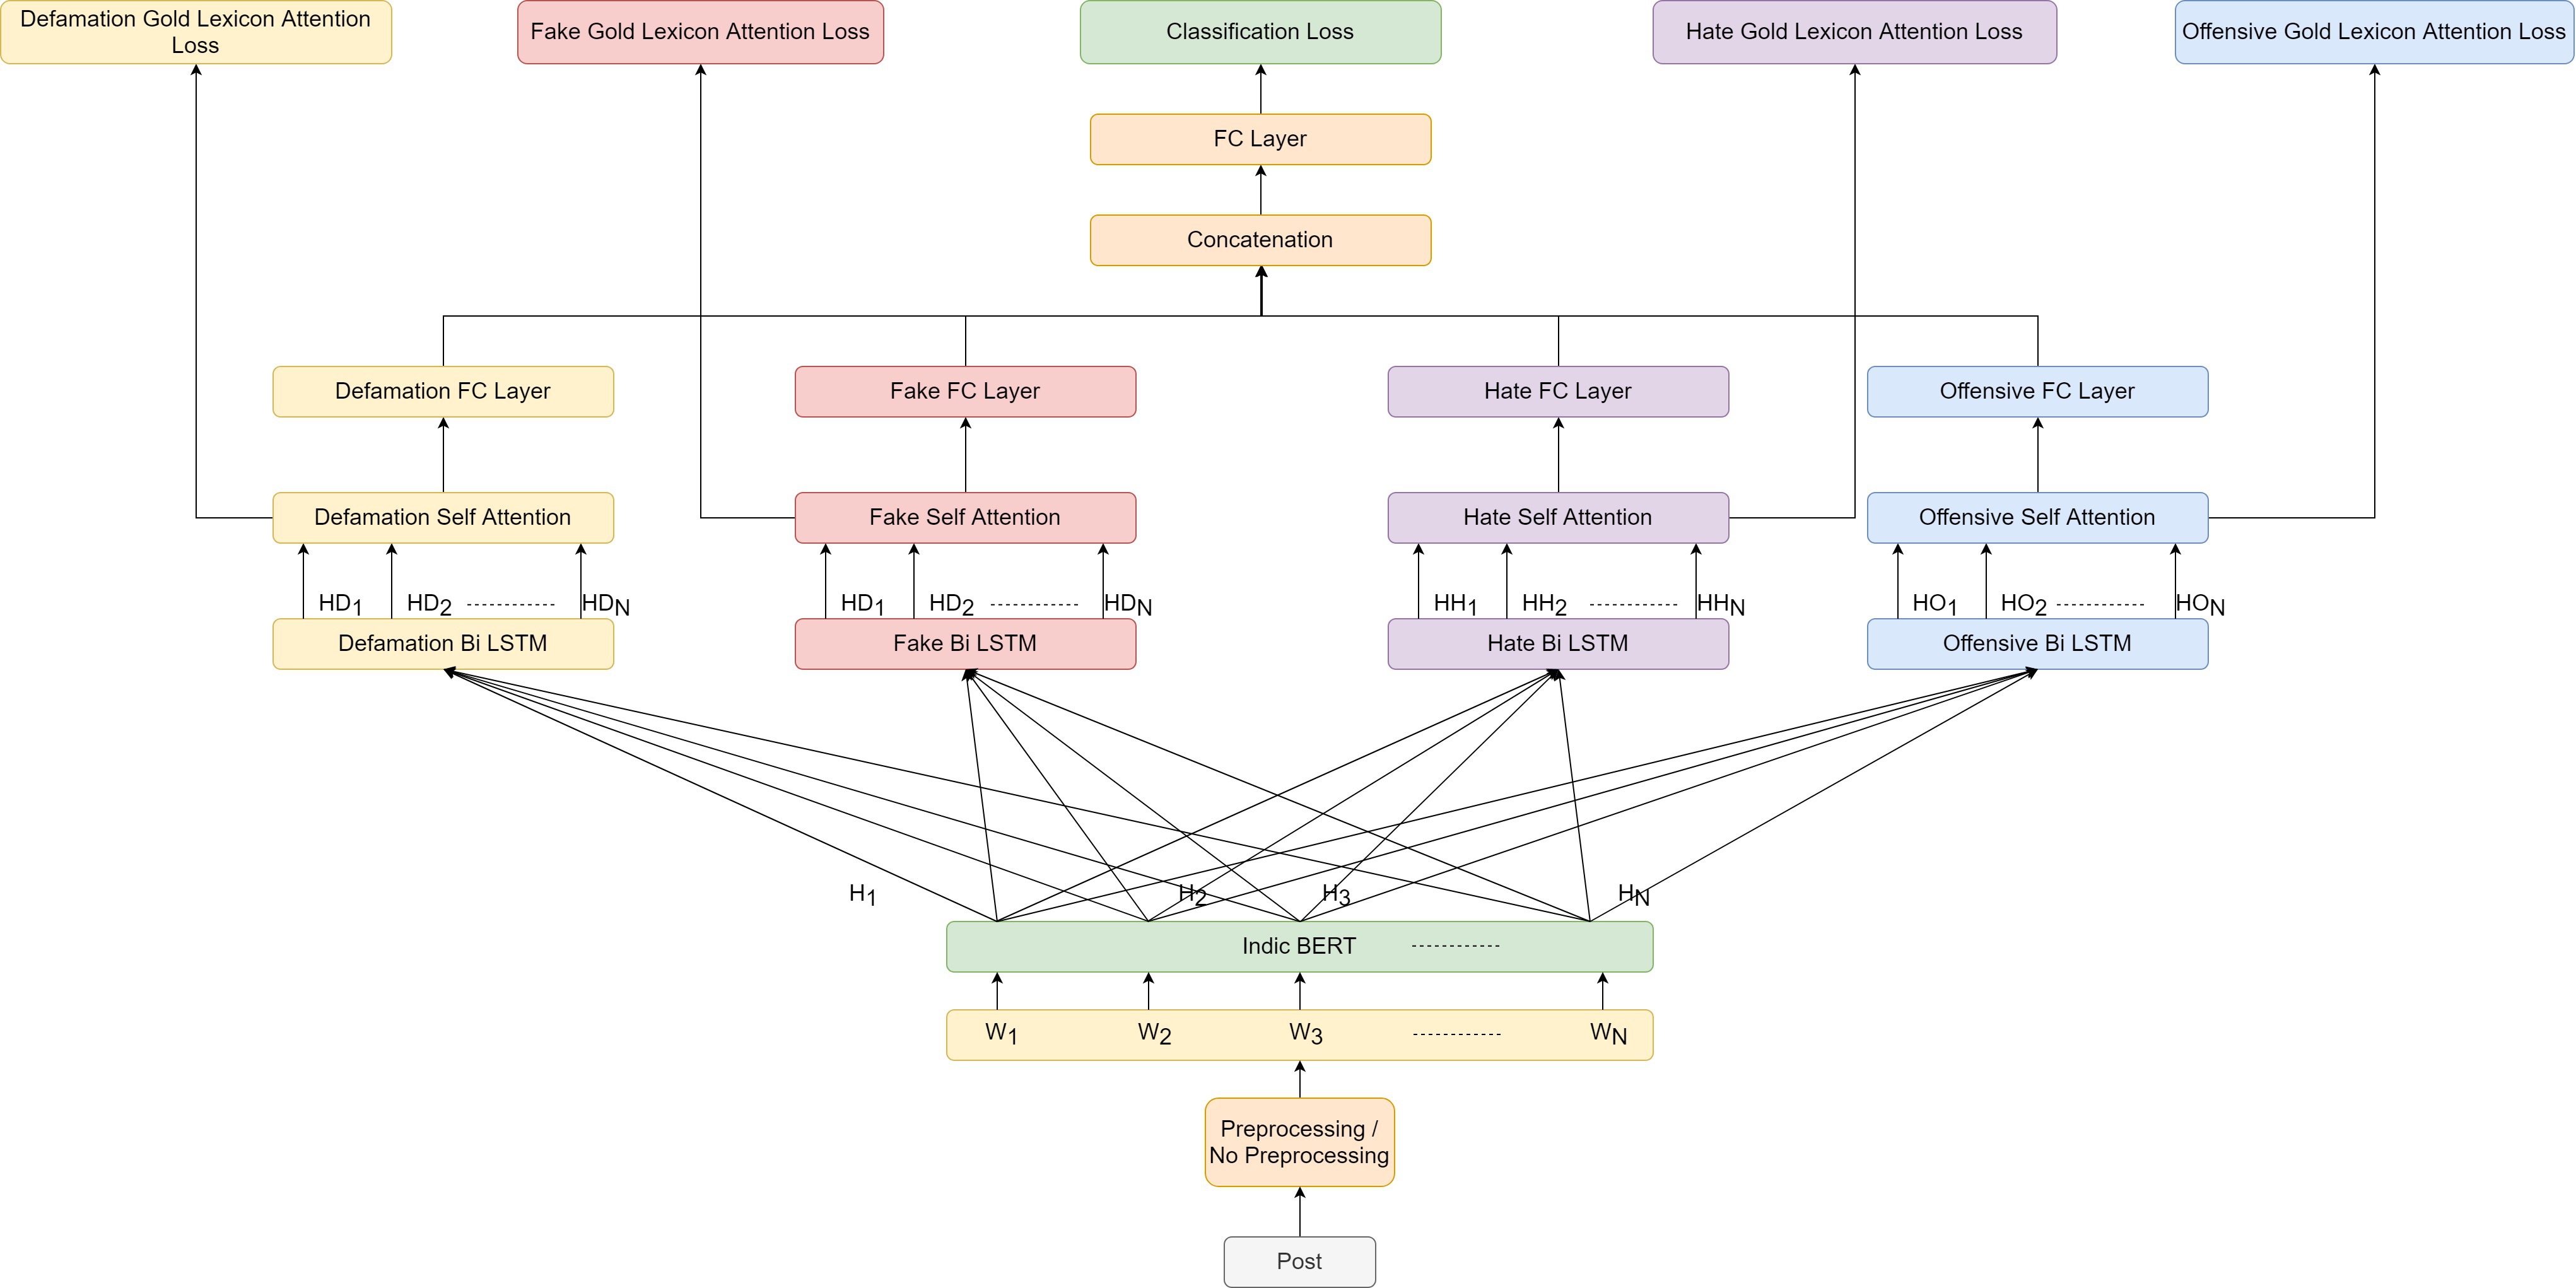

In [41]:
    from PIL import Image
    img = Image.open("Photos/SupervisedLexicon1.jpg")
    img

In [42]:
def weighted_avg(a, b):
    b = torch.unsqueeze(b,2)
    a = a.permute(0,2,1)
    c = torch.bmm(a,b)
    c = c.squeeze(2)
    return c

In [43]:
def attention_mask(vec, mask, dim=1, epsilon=1e-5):
    masked = vec * mask
    masked_sums = masked.sum(dim, keepdim=True) + epsilon
    return (masked/masked_sums)

In [44]:
# def apply_mask(a,b):
# #     b = torch.unsqueeze(b,2).expand(a.size())
#     c = torch.einsum('ab,ab -> ab', a,b)
#     c = torch.softmax(c, dim=1)
#     return c

In [45]:
# torch.manual_seed(config.SEED)

# a = torch.rand(2, 3, 4)
# b = torch.rand(2,3)

# print(a)
# print(b)
# print(weighted_avg(a,b))



In [46]:
class BaseModel2(nn.Module):
    def __init__(self):
        super(BaseModel2, self).__init__()
    
        ### Main stem ==> IndicBERT + LSTM +Attn (128) + Lexicon(LSTM) (32) + Emoji (300--> 32) ==> 192
        ### Predicted Gold Attentions: 50 each ==> 200
        ### Concat ==> 392 --> 128 --> 4
    
        self.bert_model          = AutoModel.from_pretrained(config.MODEL_PATH, output_hidden_states = config.OUTPUT_HIDDEN_STATE, output_attentions = config.OUTPUT_ATTENTIONS)
        self.dropout             = nn.Dropout(0.25)
              
#         self.complete_mha = nn.MultiheadAttention(embed_dim = 50, num_heads=5)
        self.complete_mha = nn.MultiheadAttention(embed_dim = 128, num_heads=4)


        self.lstm_lexicon                  = nn.LSTM(input_size = 4, hidden_size = 32, batch_first=True, bidirectional=True )

        ## Gave poor results with Lex Encoder
        ##self.lex_encoder_layer     = nn.TransformerEncoderLayer(d_model=4, nhead=4, dropout=0.25)
        ##self.lex_encoder           = nn.TransformerEncoder(self.lex_encoder_layer, num_layers=6) ### Seq, Batch, Embedding

        self.linear_lexicon                = nn.Linear(64, 32)
        self.linear_emoji                  = nn.Linear(300, 32)
        self.linear_hashtag                = nn.Linear(300, 32)

        
        self.concat_fc1                    = nn.Linear(864, 128)
        self.concat_fc2                    = nn.Linear(128, config.NUM_LABELS)



    def forward(self, input_ids, attention_masks, gold_attn_vectors=None, lexicon_vector=None,lexicon_masks =None, mha_masks=None, emoji_vector=None, hashtag_vector=None):
        
        output_embeddings, hidden_states, attention = self.bert_model(input_ids = input_ids, attention_mask = attention_masks).values()

        bert_attn = attention[-1]                      ### [16,4,128,128]
        
        d_bert_attn = bert_attn[:,0,:config.PAD_LENGTH,:config.PAD_LENGTH]
        f_bert_attn = bert_attn[:,1,:config.PAD_LENGTH,:config.PAD_LENGTH]
        h_bert_attn = bert_attn[:,2,:config.PAD_LENGTH,:config.PAD_LENGTH]
        o_bert_attn = bert_attn[:,3,:config.PAD_LENGTH,:config.PAD_LENGTH]

        d_bert_attn = torch.mean(d_bert_attn, 1)      ### [16,50]
        f_bert_attn = torch.mean(f_bert_attn, 1)      ### [16,50]
        h_bert_attn = torch.mean(h_bert_attn, 1)      ### [16,50]
        o_bert_attn = torch.mean(o_bert_attn, 1)      ### [16,50]
        
        d_bert_attn = attention_mask(d_bert_attn, lexicon_masks)
        f_bert_attn = attention_mask(f_bert_attn, lexicon_masks)
        h_bert_attn = attention_mask(h_bert_attn, lexicon_masks)
        o_bert_attn = attention_mask(o_bert_attn, lexicon_masks)


        ### original Input     --> N S E --> 16 128 768
        ### Transformer Input  --> S N E --> 128 16 768
        ### Transformer Output --> S N E --> 128 16 768
        
        
        concat_attn       = torch.cat((d_bert_attn, f_bert_attn, h_bert_attn, o_bert_attn),0)
        concat_attn       = concat_attn.reshape(4, len(input_ids), config.PAD_LENGTH)
        concat_attn       = self.complete_mha(concat_attn, concat_attn, concat_attn)
        concat_attn       = concat_attn[0].permute(1,0,2)
        concat_attn       = torch.flatten(concat_attn, start_dim=1)                ### [16,512]
        
#         print(concat_attn.shape)
        
        ### Main Stem --> Augmenting Lexicon Vector + Emoji Vector

        output_embeddings = torch.mean(output_embeddings, 1)
#         output_embeddings = output_embeddings[:,0,:] ### CLS EMbedding
#         print(output_embeddings.shape)
        
        lexicon_vector = lexicon_vector[:, :, :-1]
        lexicon_all_hidden_states, (lexicon_last_hidden_state, lexicon_cell_state) = self.lstm_lexicon(lexicon_vector) # [16, 50, 64]
        lexicon_sum_hidden_states = torch.sum(lexicon_all_hidden_states, 1)  ### [16,64]
        lexicon_drop = self.dropout(lexicon_sum_hidden_states)               ### [16,64]
        lexicon_linear = self.linear_lexicon(lexicon_drop)                   ### [16,32]
   
    
#         lex_op = self.lex_encoder(lexicon_vector.permute(1,0,2))
#         lex_op = lex_op.permute(1,0,2)
#         lex_op = torch.flatten(lex_op, 1)
#         lex_op = self.dropout(lex_op)

        
#         print(lex_op.shape)
        
        emoji_vector      = self.linear_emoji(emoji_vector)                  ### [16,32]  (300 --> 32)
        hashtag_vector    = self.linear_hashtag(hashtag_vector)              ### [16,32]  (300 --> 32)

        features           = torch.cat((lexicon_linear, emoji_vector,hashtag_vector),dim=1)  ### [16,96]
        features_drop      = self.dropout(features)        

        concat            = torch.cat((output_embeddings,concat_attn, features_drop),dim=1) ### [main_stem, d_out,  f_out,  h_out,  o_out]
#         print("Concat Attention Shape: ",concat.shape)

        model_outputs     = self.concat_fc1(concat)
        model_outputs     = self.concat_fc2(model_outputs)

        
        
        ### Supervised Attention Loss
        model_attentions    = [[gold_attn_vectors[:,0,:], d_bert_attn],
                               [gold_attn_vectors[:,1,:], f_bert_attn],
                               [gold_attn_vectors[:,2,:], h_bert_attn],
                               [gold_attn_vectors[:,3,:], o_bert_attn]]


        return model_outputs, model_attentions
        



<h4>Checking Model Shapes


In [47]:
batch = next(iter(test_dataloader))

b_texts             = batch['posts']['text']
b_preprocessed_texts= batch['posts']['processed_text']
b_tokenized_texts   = batch['posts']['tokenized_text']
b_input_ids         = batch['posts']['input_ids']
b_attention_masks   = batch['posts']['attention_masks']
b_lexicon           = batch['posts']['lexicon_vector']
b_lexicon_masks     = batch['posts']['lexicon_mask']
b_mha_masks         = batch['posts']['mha_mask']

b_gold_attn_vectors = batch['posts']['gold_attn_vectors']
b_emoji             = batch['posts']['emoji_vector']
b_hashtag           = batch['posts']['hashtag_vector']
b_labels            = batch['labels']


In [48]:
print(b_labels.shape)
print(b_gold_attn_vectors.shape)
print(b_lexicon.shape)

torch.Size([16, 4])
torch.Size([16, 4, 128])
torch.Size([16, 128, 5])


In [49]:
model = BaseModel2()

In [50]:
# model

In [51]:
outputs, attentions = model(b_input_ids, b_attention_masks, b_gold_attn_vectors, b_lexicon, b_lexicon_masks, b_mha_masks, b_emoji, b_hashtag)

In [52]:
outputs

tensor([[ 1.7189e-01, -4.7030e-02,  8.9586e-02, -2.6548e-01],
        [ 8.1475e-01, -2.2230e-01, -3.6452e-01,  1.3813e-01],
        [ 9.6781e-01,  1.3494e-01, -3.7142e-01, -5.0633e-01],
        [ 5.3768e-01, -1.9245e-02,  9.1958e-03, -4.8545e-01],
        [ 6.2642e-01,  2.5407e-01, -3.4163e-01,  8.1102e-03],
        [ 2.2342e-01, -2.2521e-01, -1.0224e-01,  4.0946e-01],
        [ 9.6520e-01, -8.2079e-04,  2.1080e-01,  1.6954e-01],
        [ 5.0850e-01, -2.3955e-01,  1.7737e-02,  1.5063e-01],
        [ 1.7901e-02, -2.2860e-01,  1.0269e-01,  5.6667e-01],
        [ 6.1192e-01,  5.7488e-02,  9.6034e-02, -5.9424e-02],
        [ 4.2068e-01, -1.4381e-01,  2.3220e-01,  3.2719e-01],
        [ 1.8479e-01,  6.6497e-03,  9.7597e-03,  1.4801e-01],
        [ 8.2630e-01,  2.1567e-01,  1.3438e-02,  1.5479e-01],
        [ 5.0344e-01, -1.3630e-01, -3.8212e-01,  3.6054e-01],
        [ 5.2203e-01, -1.5170e-01, -2.4460e-01,  2.6003e-01],
        [ 7.5219e-01, -7.9326e-02,  8.6374e-02, -1.6060e-01]],
       

In [53]:
attentions[0][1][0][:5]

tensor([0.0000, 0.0570, 0.0775, 0.0849, 0.2031], grad_fn=<SliceBackward>)

In [54]:
sum(attentions[0][1][0])

tensor(1.0000, grad_fn=<AddBackward0>)

In [55]:
# print(sum(b_gold_attn_vectors[0][0]))
# print(sum(b_gold_attn_vectors[0][1]))


# print(len(b_texts[0].split()))


# print(sum(b_lexicon_masks[0]))


# print("\n\n",b_tokenized_texts[0])


# print(b_lexicon_masks[0])

# for i,j in zip(b_tokenized_texts[0].split(),b_lexicon_masks[0]):
#     print(i," --> ", j)

<h4> Custom Loss Function

In [56]:
class Supervised_Attention_Loss(nn.Module):
    def __init__(self):
        super(Supervised_Attention_Loss,self).__init__()
        
    def forward(self, targets, outputs):
        outputs = torch.log_softmax(outputs, dim=1)
        loss    = -torch.sum(targets * outputs) / len(targets)
        return loss

<h4> Trying KL Div Loss
    

In [57]:
torch.manual_seed(42)

a = torch.rand(3)
a = a/sum(a)
b = torch.rand(3)
b = b/sum(b)
print(a)
print(b)

c = nn.KLDivLoss(reduction='batchmean')

print(c(a,b))
print(c(a.log(),b))
print(c(b.log(),a))

print((b*(b.log()-a.log())).sum())

tensor([0.4047, 0.4197, 0.1756])
tensor([0.4918, 0.2002, 0.3080])
tensor(-0.4570)
tensor(0.0403)
tensor(0.0444)
tensor(0.1208)


#### Train Function

In [58]:
def train(model, train_dataloader, criterion_clf, supervised_attn_loss, optimizer, scheduler, epoch):
    
    
    true              = []
    pred              = []
    train_loss        = 0
    num_correct       = 0
    num_samples       = 0
    num_iterations    = len(train_dataloader)
    output_embeddings = {'embeddings':[], 'labels':[]}
    loop              = tqdm(enumerate(train_dataloader), leave=True, position=0)
    
    for step, batch in loop:
        # set model.train() every time during training
            
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_input_ids       = batch['posts']['input_ids'].to(config.DEVICE)
        b_attention_masks = batch['posts']['attention_masks'].to(config.DEVICE)
        b_labels          = batch['labels'].to(config.DEVICE)

        
        b_lexicon           = batch['posts']['lexicon_vector'].to(config.DEVICE)
        b_lexicon_masks     = batch['posts']['lexicon_mask'].to(config.DEVICE)
        b_mha_masks         = batch['posts']['mha_mask'].to(config.DEVICE)

        b_emoji             = batch['posts']['emoji_vector'].to(config.DEVICE)
        b_hashtag           = batch['posts']['hashtag_vector'].to(config.DEVICE)
        b_gold_attn_vectors = batch['posts']['gold_attn_vectors'].to(config.DEVICE)

        
        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        logits,model_attentions =  model(b_input_ids, b_attention_masks, b_gold_attn_vectors, b_lexicon, b_lexicon_masks, b_mha_masks, b_emoji, b_hashtag)
        
        # calculate loss
        d_loss        = supervised_attn_loss(model_attentions[0][0], model_attentions[0][1])
        f_loss        = supervised_attn_loss(model_attentions[1][0], model_attentions[1][1])
        h_loss        = supervised_attn_loss(model_attentions[2][0], model_attentions[2][1])
        o_loss        = supervised_attn_loss(model_attentions[3][0], model_attentions[3][1])

        clf_loss      = criterion_clf(logits, b_labels)
        
        loss = clf_loss  + config.DEFAMATION_LOSS_LAMBDA * d_loss\
                         + config.FAKE_LOSS_LAMBDA * f_loss\
                         + config.HATE_LOSS_LAMBDA * h_loss\
                         + config.DEFAMATION_LOSS_LAMBDA * o_loss
        
        train_loss += loss.item()
        
        
        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        logits = logits.detach()
        logits = torch.sigmoid(logits)
        logits = np.round(logits.cpu().numpy())
        labels = b_labels.cpu().numpy()

        true.extend(labels)
        pred.extend(logits)

        if(config.COARSE_GRAINED):
            num_correct += (logits == labels).sum()
        else:
            count = 0
            for i,j in zip(logits, labels):
                if (i==j).sum() == config.NUM_LABELS:
                    count += 1
            num_correct +=  count

        num_samples += len(b_labels)
        accuracy    = (num_correct/num_samples)*100
        pred        = list(np.nan_to_num(pred))
        f1          = f1_score(true, pred, average='weighted')

        ### Saving Model Embeddings with Labels for visualization
        output_embeddings['embeddings'].extend(logits)
        output_embeddings['labels'].extend(b_labels.cpu().numpy())


        loop.set_description(f'Epoch [{epoch+1}/{config.EPOCHS}] Batch [{step+1}/{len(train_dataloader)}]')
        loop.set_postfix(Loss = f'{train_loss/(step+1):0.4f}', Correct = f'{num_correct}/{num_samples}', accuracy = accuracy, f1_score = f1)

    train_loss = train_loss / len(train_dataloader)
    print("Train loss for epoch ",epoch," is: ",train_loss)

    
    return train_loss, output_embeddings


#### Check Accuracy

In [59]:
def check_accuracy(model, dataloader, criterion_clf, supervised_attn_loss, name=None):

    total_loss     = 0
    total_d_loss   = 0
    total_f_loss   = 0
    total_h_loss   = 0
    total_o_loss   = 0
    total_clf_loss = 0

    true, pred   = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_input_ids       = batch['posts']['input_ids'].to(config.DEVICE)
        b_attention_masks = batch['posts']['attention_masks'].to(config.DEVICE)
        b_labels          = batch['labels'].to(config.DEVICE)

        
        b_lexicon           = batch['posts']['lexicon_vector'].to(config.DEVICE)
        b_lexicon_masks     = batch['posts']['lexicon_mask'].to(config.DEVICE)
        b_mha_masks         = batch['posts']['mha_mask'].to(config.DEVICE)

        b_emoji             = batch['posts']['emoji_vector'].to(config.DEVICE)
        b_hashtag           = batch['posts']['hashtag_vector'].to(config.DEVICE)
        b_gold_attn_vectors = batch['posts']['gold_attn_vectors'].to(config.DEVICE)


        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        
        with torch.no_grad():
            # forward pass
            logits,model_attentions =  model(b_input_ids, b_attention_masks, b_gold_attn_vectors, b_lexicon, b_lexicon_masks, b_mha_masks, b_emoji, b_hashtag)

            # calculate loss
            d_loss        = supervised_attn_loss(model_attentions[0][0], model_attentions[0][1])
            f_loss        = supervised_attn_loss(model_attentions[1][0], model_attentions[1][1])
            h_loss        = supervised_attn_loss(model_attentions[2][0], model_attentions[2][1])
            o_loss        = supervised_attn_loss(model_attentions[3][0], model_attentions[3][1])

            clf_loss      = criterion_clf(logits, b_labels)

            loss = clf_loss  + config.DEFAMATION_LOSS_LAMBDA * d_loss\
                             + config.FAKE_LOSS_LAMBDA * f_loss\
                             + config.HATE_LOSS_LAMBDA * h_loss\
                             + config.DEFAMATION_LOSS_LAMBDA * o_loss
            
            total_d_loss   += config.DEFAMATION_LOSS_LAMBDA * d_loss.item()
            total_f_loss   += config.FAKE_LOSS_LAMBDA * f_loss.item()
            total_h_loss   += config.HATE_LOSS_LAMBDA * h_loss.item()
            total_o_loss   += config.DEFAMATION_LOSS_LAMBDA * o_loss.item()
            total_clf_loss += clf_loss.item()

            total_loss     += loss.item()
        


            # since we're using BCEWithLogitsLoss, to get the predictions -
            # - sigmoid has to be applied on the logits first
            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()
        
            # the tensors are detached from the gpu and put back on -
            # - the cpu, and then converted to numpy in order to -
            # - use sklearn's metrics.

            pred.extend(logits)
            true.extend(labels)

    print("\n\n",name," Attention Loss\n")
    print("Defamation Supervised Attention Loss: ", total_d_loss/len(dataloader))
    print("Fake Supervised Attention Loss:       ", total_f_loss/len(dataloader))
    print("Hate Supervised Attention Loss:       ", total_h_loss/len(dataloader))
    print("Offensive Supervised Attention Loss:  ", total_o_loss/len(dataloader))
    print("Classifier Supervised Attention Loss: ", total_clf_loss/len(dataloader),"\n\n")
    
    
    avg_loss = total_loss / len(dataloader)
    
    
    print("Total ",name," Loss",avg_loss)
    pred = list(np.nan_to_num(pred))

    
    
    if(config.COARSE_GRAINED):
        f1 = f1_score(true, pred, average='weighted')
        print("\n",name," Coarse Grained Scores: ", f1)

        warnings.filterwarnings('ignore')
        print("\n\n",classification_report(true,pred))
        warnings.filterwarnings('default')

    
    else:
        scores = f1_score(true, pred, average=None)
        cname = { 0: "Defamation", 1: "Fake      ", 2: "Hate      ", 3: "Offensive "}
        print("\n\n",name," Individual Class Scores: ")
        for i,item in enumerate(scores):
            print(f'{cname[i]} F1 Score: {item:10.4f}')

            
        f1 = f1_score(true, pred, average='weighted')
        print("\n",name," Weighted F1 - Score (For Fine Grained - Hostile Posts Only): ", f1)
        warnings.filterwarnings('ignore')
        print("\n\n",classification_report(true,pred))
        warnings.filterwarnings('default')

    
    return avg_loss, f1,  (total_d_loss/len(train_dataloader),total_f_loss/len(train_dataloader),total_h_loss/len(train_dataloader),total_o_loss/len(train_dataloader))

#### Run

In [60]:
def run(train_dataloader, val_dataloader, test_dataloader, model_path, model_name, checkpoint = None):

    print("Training Model: ",model_name,"\n\n")
    # setting a seed ensures reproducible results. seed may affect the performance too.
    
    if(config.COARSE_GRAINED!=True):
        pos_weight = torch.tensor([4.74, 2.34, 3.38, 3.64]).to(config.DEVICE)
    else:
        pos_weight = torch.tensor([1.13]).to(config.DEVICE)
        
    criterion_clf        = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    supervised_attn_loss = nn.MSELoss()

    
    
    
    model = BaseModel2()
    model.to(config.DEVICE)

    print("\n\n-----------------------Training---------------------------\n\n")
    
    
    
    # define the parameters to be optmized and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [    {
                                        "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                        "weight_decay": 0.001,
                                    },
                                    {
                                        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                        "weight_decay": 0.0,
                                    }]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=num_training_steps)
    
    max_val_f1_score = float('-inf')

    if(checkpoint != None):
        print("\n\n------------------- Loading Checkpoint-----------------------\n\n")
        warnings.filterwarnings("ignore")
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        max_val_f1_score = checkpoint['val_f1_score']
        warnings.filterwarnings("default")
    
    max_val_f1_score = float('-inf')

   
    if(config.PLOT_LOSS):
        train_losses = []
        valid_losses = []
        test_losses  = []
        
        train_d_losses = []
        train_f_losses = []
        train_h_losses = []
        train_o_losses = []
        
        val_d_losses = []
        val_f_losses = []
        val_h_losses = []
        val_o_losses = []
        
        test_d_losses = []
        test_f_losses = []
        test_h_losses = []
        test_o_losses = []
        

    for epoch in range(config.EPOCHS):
        train_loss,output_embeddings  = train(model, train_dataloader, criterion_clf, supervised_attn_loss, optimizer, scheduler, epoch)        
        
        print("\n\nTrain Results\n\n", "*"*60, "\n\n")
        train_loss,train_f1_score, train_attn_losses  = check_accuracy(model, train_dataloader, criterion_clf, supervised_attn_loss, "Train")
        
        print("\n\nVal Results\n\n", "*"*60, "\n\n")
        valid_loss,val_f1_score,val_attn_losses       = check_accuracy(model, val_dataloader, criterion_clf, supervised_attn_loss, "Validation")
        
        print("\n\nTest Results\n\n", "*"*60, "\n\n")
        test_loss,val_f1_score, test_attn_losses      = check_accuracy(model, test_dataloader, criterion_clf, supervised_attn_loss, "Test")
        
        
        if(config.PLOT_LOSS):
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            test_losses.append(test_loss)
            
            train_d_losses.append(train_attn_losses[0])
            train_f_losses.append(train_attn_losses[1])
            train_h_losses.append(train_attn_losses[2])
            train_o_losses.append(train_attn_losses[3])
            
            val_d_losses.append(val_attn_losses[0])
            val_f_losses.append(val_attn_losses[1])
            val_h_losses.append(val_attn_losses[2])
            val_o_losses.append(val_attn_losses[3])
            
#             test_d_losses.append(test_attn_losses[0])
#             test_f_losses.append(test_attn_losses[1])
#             test_h_losses.append(test_attn_losses[2])
#             test_o_losses.append(test_attn_losses[3])


        if(config.VISUALIZE_EMBEDDINGS):
            embeddings = output_embeddings['embeddings']
            labels     = output_embeddings['labels']
    
            embeddings = np.nan_to_num(embeddings)
        
            if(config.COARSE_GRAINED):
                labels     = [int(label) for sublist in labels for label in sublist]    
            else:
                labels = np.array(labels, dtype=int)
            plot_tsne(embeddings, labels)

            
        if config.SAVE_BEST_ONLY:
            warnings.filterwarnings("ignore")
            if val_f1_score > max_val_f1_score:
                max_val_f1_score = val_f1_score

                checkpoint = { 'state_dict'   : model.state_dict(), 
                               'optimizer'    : optimizer.state_dict(),
                               'scheduler'    : scheduler.state_dict(),
                               'val_loss'     : valid_loss,
                               'val_f1_score' : val_f1_score}

                checkpoint_path = model_path + model_name + ' F1 - ' +str(val_f1_score) + ' Epoch ' + str(epoch+1) + '.pt'
                torch.save(checkpoint, checkpoint_path)
                print("\n\n--------------------Model Saved------------------\n\n")
                

            else:
                checkpoint_path = None
            warnings.filterwarnings("default")
        else:
            checkpoint_path = None


    if(config.PLOT_LOSS):
        
        #         SMALL_SIZE = 15
#         MEDIUM_SIZE = 20
#         BIGGER_SIZE = 25
#         line_width = 3

#         plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#         plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
#         plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#         plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#         plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#         plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#         plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


        line_width  = 3
        marker_size = 13
        plt.rcParams['font.family'] = "Times New Roman"
        plt.rcParams['font.size'] = 23
        
        
        x = np.arange(1,len(valid_losses)+1)
        plt.figure(figsize=(10,15))
        plt.plot(x,train_losses, color='orange',label='Train Loss', marker = 'o', linewidth = line_width)
        plt.plot(x,valid_losses, color='blue',  label='Valid Loss', marker = 'o', linewidth = line_width)
#         plt.plot(x,test_losses, color='red',    label='Test Loss', marker = 'x')
        plt.legend()
        plt.show()
        
        
        x = np.arange(1,len(train_d_losses)+1)
        plt.figure(figsize=(20,20))
        
        plt.plot(x,train_d_losses, color='orange', label='Train DAL', marker = 'o', linewidth = line_width, markersize = marker_size)
        plt.plot(x,train_f_losses, color='blue',   label='Train FAL', marker = 's', linewidth = line_width, markersize = marker_size)
        plt.plot(x,train_h_losses, color='red',    label='Train HAL', marker = 'P', linewidth = line_width, markersize = marker_size)
        plt.plot(x,train_o_losses, color='green',  label='Train OAL', marker = '^', linewidth = line_width, markersize = marker_size)
        
        plt.plot(x,val_d_losses, color='orange', label='Val DAL', marker = 'o', linestyle = '--', linewidth = line_width, markersize = marker_size)
        plt.plot(x,val_f_losses, color='blue',   label='Val FAL', marker = 's', linestyle = '--', linewidth = line_width, markersize = marker_size)
        plt.plot(x,val_h_losses, color='red',    label='Val HAL', marker = 'P', linestyle = '--', linewidth = line_width, markersize = marker_size)
        plt.plot(x,val_o_losses, color='green',  label='Val OAL', marker = '^', linestyle = '--', linewidth = line_width, markersize = marker_size)
        
#         plt.plot(x,test_d_losses, color='orange', label='Test DAL', marker = '^', linestyle = '-.', linewidth=2)
#         plt.plot(x,test_f_losses, color='blue',   label='Test FAL', marker = '^', linestyle = '-.', linewidth=2)
#         plt.plot(x,test_h_losses, color='red',    label='Test HAL', marker = '^', linestyle = '-.', linewidth=2)
#         plt.plot(x,test_o_losses, color='green',  label='Test OAL', marker = '^', linestyle = '-.', linewidth=2)

        
        plt.legend()
        if(config.COARSE_GRAINED != True):
            plt.savefig('BCE + MSE Total Loss.pdf', bbox_inches='tight')
        plt.show()

        
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))

        counter = 0
        x       = np.arange(1, len(train_d_losses)+1)
        attn    = [[train_d_losses, train_f_losses, train_h_losses, train_o_losses],
                   [val_d_losses, val_f_losses, val_h_losses, val_o_losses]]
                           
        word    = ["Train ", "Validation "]

        for i in range(len(word)):
            scores = attn[counter]
            axes[counter].plot(x,scores[0], color='orange', label='DAL', marker = 'o', linewidth = line_width, markersize = marker_size)
            axes[counter].plot(x,scores[1], color='blue',   label='FAL', marker = 's', linewidth = line_width, markersize = marker_size)
            axes[counter].plot(x,scores[2], color='red',    label='HAL', marker = 'P', linewidth = line_width, markersize = marker_size)
            axes[counter].plot(x,scores[3], color='green',  label='OAL', marker = '^', linewidth = line_width, markersize = marker_size)

            title = word[counter] + " Attention Losses"
            axes[counter].set_xlabel("Epochs")
            axes[counter].set_ylabel("Loss Value")
            axes[counter].set_title(title)
            axes[counter].legend()
            counter += 1
            
        
        if(config.COARSE_GRAINED != True):
            plt.savefig('BCE + MSE Attn Loss.pdf', bbox_inches='tight')
        plt.show()
        
        losses = {'train_d_losses' : train_d_losses, 'train_f_losses': train_f_losses, 'train_h_losses': train_h_losses, 'train_o_losses': train_o_losses,
              'val_d_losses': val_d_losses, 'val_f_losses': val_f_losses, 'val_h_losses': val_h_losses, 'val_o_losses': val_o_losses}
    
        pickle.dump(losses, open("Raw Text with Emoji Attn Losses.pkl", 'wb'))

    
    
    return model, checkpoint_path, (train_losses, valid_losses, test_losses)

<h3>Fine Grained Training from Scratch

#### Fine-Grained on Entire Dataset

In [61]:
config.NUM_LABELS       = 4
config.COARSE_GRAINED   = False
config.SERVER           = True
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = False

config.PERCENTAGE_DATA  = 100
config.LR               = 0.0001
config.EPOCHS           = 30

### Loss Hyperparameters
config.DEFAMATION_LOSS_LAMBDA = 4.74
config.FAKE_LOSS_LAMBDA       = 2.34
config.HATE_LOSS_LAMBDA       = 3.38
config.OFFENSIVE_LOSS_LAMBDA  = 3.64

In [62]:
torch.manual_seed(config.SEED)

# train_dataset = HindiHostilityDataset("Data/pkl_combined_fine_train.pkl")
train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

Taking  2678  only
Taking  376  only
Taking  780  only


In [63]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=True)


Training Model:  PreHBT + concat Attn + LEH +BCE+MSE -  




0it [00:00, ?it/s]



-----------------------Training---------------------------




Epoch [1/30] Batch [168/168]: : 168it [00:30,  5.58it/s, Correct=444/2678, Loss=1.0581, accuracy=16.6, f1_score=0.541]


Train loss for epoch  0  is:  1.0581006113262403


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0003019305678325119
Fake Supervised Attention Loss:        0.00035770150503594794
Hate Supervised Attention Loss:        0.00016527059174222818
Offensive Supervised Attention Loss:   0.0001827858237610208
Classifier Supervised Attention Loss:  0.9469786658883095 


Total  Train  Loss 0.9479863519469897


 Train  Individual Class Scores: 
Defamation F1 Score:     0.4307
Fake       F1 Score:     0.7575
Hate       F1 Score:     0.5410
Offensive  F1 Score:     0.5597

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6024740110399809


               precision    recall  f1-score   support

           0       0.29      0.85      0.43       564
           1       0.73      0.79      0.76      1144
           2       0.39      0.88      0.54       792
           3       0.41 

Epoch [2/30] Batch [1/168]: : 1it [00:00,  6.63it/s, Correct=4/16, Loss=1.0975, accuracy=25, f1_score=0.608]



--------------------Model Saved------------------




Epoch [2/30] Batch [168/168]: : 168it [00:30,  5.53it/s, Correct=685/2678, Loss=0.9321, accuracy=25.6, f1_score=0.606]


Train loss for epoch  1  is:  0.9320615331331888


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00030869573860400093
Fake Supervised Attention Loss:        0.00034619453730296544
Hate Supervised Attention Loss:        0.00016988726939416656
Offensive Supervised Attention Loss:   0.00018976435160441592
Classifier Supervised Attention Loss:  0.8355750136432194 


Total  Train  Loss 0.8365895613318398


 Train  Individual Class Scores: 
Defamation F1 Score:     0.4618
Fake       F1 Score:     0.8197
Hate       F1 Score:     0.5597
Offensive  F1 Score:     0.5945

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6423682517183082


               precision    recall  f1-score   support

           0       0.30      0.95      0.46       564
           1       0.83      0.81      0.82      1144
           2       0.40      0.96      0.56       792
           3       0.4

0it [00:00, ?it/s]



--------------------Model Saved------------------




Epoch [3/30] Batch [168/168]: : 168it [00:33,  5.02it/s, Correct=783/2678, Loss=0.8401, accuracy=29.2, f1_score=0.641]


Train loss for epoch  2  is:  0.8401115518950281


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00027630062361432846
Fake Supervised Attention Loss:        0.00023464050357298598
Hate Supervised Attention Loss:        0.0001523302833129492
Offensive Supervised Attention Loss:   0.0001742306665885605
Classifier Supervised Attention Loss:  0.7537014415221555 


Total  Train  Loss 0.7545389465632892


 Train  Individual Class Scores: 
Defamation F1 Score:     0.4878
Fake       F1 Score:     0.8685
Hate       F1 Score:     0.5960
Offensive  F1 Score:     0.6081

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6761113367834652


               precision    recall  f1-score   support

           0       0.33      0.96      0.49       564
           1       0.88      0.86      0.87      1144
           2       0.44      0.94      0.60       792
           3       0.45 

0it [00:00, ?it/s]



--------------------Model Saved------------------




Epoch [4/30] Batch [168/168]: : 168it [00:34,  4.83it/s, Correct=886/2678, Loss=0.7793, accuracy=33.1, f1_score=0.67] 


Train loss for epoch  3  is:  0.7793092081944147


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0003014059549760921
Fake Supervised Attention Loss:        0.0002867968165654541
Hate Supervised Attention Loss:        0.00015902002964204647
Offensive Supervised Attention Loss:   0.00018356961428253268
Classifier Supervised Attention Loss:  0.6953768155404499 


Total  Train  Loss 0.6963076103656065


 Train  Individual Class Scores: 
Defamation F1 Score:     0.6045
Fake       F1 Score:     0.8624
Hate       F1 Score:     0.6240
Offensive  F1 Score:     0.6568

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.7122152117768485


               precision    recall  f1-score   support

           0       0.46      0.89      0.60       564
           1       0.82      0.91      0.86      1144
           2       0.47      0.94      0.62       792
           3       0.51 

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0003254440293631906
Fake Supervised Attention Loss:        0.00030334015366174655
Hate Supervised Attention Loss:        0.00017146210710497863
Offensive Supervised Attention Loss:   0.00020121673004370902
Classifier Supervised Attention Loss:  0.921704635328176 


Total  Test  Loss 0.9227061010136897


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4426
Fake       F1 Score:     0.7935
Hate       F1 Score:     0.5761
Offensive  F1 Score:     0.6101

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.636236080815105


               precision    recall  f1-score   support

           0       0.34      0.64      0.44       169
           1       0.72      0.88      0.79       334
           2       0.44      0.83      0.58       234
           3       0.49      0.80      0.61       219

   micro avg       0.51      0.81      0.62       956
   macro avg       0.50      0.79      0.61       9

Epoch [5/30] Batch [168/168]: : 168it [00:33,  4.96it/s, Correct=1020/2678, Loss=0.7047, accuracy=38.1, f1_score=0.705]


Train loss for epoch  4  is:  0.7047167929510275


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0002692412806469031
Fake Supervised Attention Loss:        0.00025825974030470073
Hate Supervised Attention Loss:        0.00015125916280339874
Offensive Supervised Attention Loss:   0.0001703113156749428
Classifier Supervised Attention Loss:  0.6237692932287852 


Total  Train  Loss 0.6246183680459148


 Train  Individual Class Scores: 
Defamation F1 Score:     0.5895
Fake       F1 Score:     0.9150
Hate       F1 Score:     0.6390
Offensive  F1 Score:     0.6397

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.7279047522092716


               precision    recall  f1-score   support

           0       0.43      0.94      0.59       564
           1       0.94      0.89      0.91      1144
           2       0.48      0.96      0.64       792
           3       0.47 

0it [00:00, ?it/s]



--------------------Model Saved------------------




Epoch [6/30] Batch [168/168]: : 168it [00:31,  5.27it/s, Correct=1102/2678, Loss=0.6506, accuracy=41.2, f1_score=0.724]


Train loss for epoch  5  is:  0.6506277750290576


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00036439996237796937
Fake Supervised Attention Loss:        0.00035009831337187535
Hate Supervised Attention Loss:        0.00016428515016828207
Offensive Supervised Attention Loss:   0.00019475008146270864
Classifier Supervised Attention Loss:  0.5762558432207221 


Total  Train  Loss 0.5773293746724015


 Train  Individual Class Scores: 
Defamation F1 Score:     0.6444
Fake       F1 Score:     0.9164
Hate       F1 Score:     0.6585
Offensive  F1 Score:     0.6734

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.7504492835748293


               precision    recall  f1-score   support

           0       0.49      0.93      0.64       564
           1       0.91      0.92      0.92      1144
           2       0.52      0.91      0.66       792
           3       0.5

Epoch [7/30] Batch [1/168]: : 1it [00:00,  6.92it/s, Correct=8/16, Loss=0.6080, accuracy=50, f1_score=0.798]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0003906528519930398
Fake Supervised Attention Loss:        0.00038568601014011785
Hate Supervised Attention Loss:        0.0001818430458304795
Offensive Supervised Attention Loss:   0.00021737949589620184
Classifier Supervised Attention Loss:  1.0330904369451561 


Total  Test  Loss 1.034266003540584


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4619
Fake       F1 Score:     0.8022
Hate       F1 Score:     0.5677
Offensive  F1 Score:     0.6014

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6386251580084719


               precision    recall  f1-score   support

           0       0.35      0.66      0.46       169
           1       0.74      0.87      0.80       334
           2       0.46      0.74      0.57       234
           3       0.49      0.79      0.60       219

   micro avg       0.52      0.78      0.63       956
   macro avg       0.51      0.76      0.61       9

Epoch [7/30] Batch [168/168]: : 168it [00:27,  6.15it/s, Correct=1203/2678, Loss=0.6088, accuracy=44.9, f1_score=0.743]


Train loss for epoch  6  is:  0.6088242981405485


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00045702676230186104
Fake Supervised Attention Loss:        0.0005058025843728893
Hate Supervised Attention Loss:        0.00017464487279626368
Offensive Supervised Attention Loss:   0.00019749522642346822
Classifier Supervised Attention Loss:  0.5342233905657416 


Total  Train  Loss 0.5355583587217898


 Train  Individual Class Scores: 
Defamation F1 Score:     0.6553
Fake       F1 Score:     0.9208
Hate       F1 Score:     0.6844
Offensive  F1 Score:     0.6859

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.7630946808206353


               precision    recall  f1-score   support

           0       0.51      0.92      0.66       564
           1       0.92      0.92      0.92      1144
           2       0.54      0.93      0.68       792
           3       0.53

Epoch [8/30] Batch [1/168]: : 1it [00:00,  6.21it/s, Correct=6/16, Loss=0.4743, accuracy=37.5, f1_score=0.752]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00048041172799736273
Fake Supervised Attention Loss:        0.0005182368320496682
Hate Supervised Attention Loss:        0.00019277888829214023
Offensive Supervised Attention Loss:   0.00021498056350018096
Classifier Supervised Attention Loss:  1.0205051582686755 


Total  Test  Loss 1.0219115754779504


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4562
Fake       F1 Score:     0.8067
Hate       F1 Score:     0.5714
Offensive  F1 Score:     0.6035

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6406149385483159


               precision    recall  f1-score   support

           0       0.35      0.66      0.46       169
           1       0.76      0.86      0.81       334
           2       0.47      0.73      0.57       234
           3       0.49      0.79      0.60       219

   micro avg       0.52      0.78      0.63       956
   macro avg       0.52      0.76      0.61      

Epoch [8/30] Batch [168/168]: : 168it [00:27,  6.09it/s, Correct=1252/2678, Loss=0.5678, accuracy=46.8, f1_score=0.757]


Train loss for epoch  7  is:  0.5677961102198987


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0004990012572722793
Fake Supervised Attention Loss:        0.0004465181938576277
Hate Supervised Attention Loss:        0.00019180637389235063
Offensive Supervised Attention Loss:   0.00020771520109909552
Classifier Supervised Attention Loss:  0.5007608366154489 


Total  Train  Loss 0.5021058791982276


 Train  Individual Class Scores: 
Defamation F1 Score:     0.6873
Fake       F1 Score:     0.9425
Hate       F1 Score:     0.6949
Offensive  F1 Score:     0.6707

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.775411576472186


               precision    recall  f1-score   support

           0       0.55      0.92      0.69       564
           1       0.97      0.92      0.94      1144
           2       0.55      0.95      0.69       792
           3       0.51  

Epoch [9/30] Batch [1/168]: : 1it [00:00,  7.01it/s, Correct=4/16, Loss=0.6191, accuracy=25, f1_score=0.71]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0005794633924099853
Fake Supervised Attention Loss:        0.0004787463428689006
Hate Supervised Attention Loss:        0.00021797287754081335
Offensive Supervised Attention Loss:   0.0002354058044652539
Classifier Supervised Attention Loss:  1.0263487879110842 


Total  Test  Loss 1.0278603799489079


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4612
Fake       F1 Score:     0.7994
Hate       F1 Score:     0.5710
Offensive  F1 Score:     0.6169

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6419142035413645


               precision    recall  f1-score   support

           0       0.35      0.67      0.46       169
           1       0.77      0.83      0.80       334
           2       0.47      0.74      0.57       234
           3       0.49      0.83      0.62       219

   micro avg       0.52      0.78      0.63       956
   macro avg       0.52      0.77      0.61       9

Epoch [9/30] Batch [168/168]: : 168it [00:27,  6.20it/s, Correct=1319/2678, Loss=0.5309, accuracy=49.3, f1_score=0.776]


Train loss for epoch  8  is:  0.5309430156790075


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0004934399291752405
Fake Supervised Attention Loss:        0.0007053930882648272
Hate Supervised Attention Loss:        0.00019849952869424752
Offensive Supervised Attention Loss:   0.0002153972965899292
Classifier Supervised Attention Loss:  0.4530660767285597 


Total  Train  Loss 0.45467880758501233


 Train  Individual Class Scores: 
Defamation F1 Score:     0.6654
Fake       F1 Score:     0.9493
Hate       F1 Score:     0.7057
Offensive  F1 Score:     0.7495

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.7946650327644826


               precision    recall  f1-score   support

           0       0.51      0.96      0.67       564
           1       0.98      0.92      0.95      1144
           2       0.56      0.95      0.71       792
           3       0.61 

Epoch [10/30] Batch [1/168]: : 1it [00:00,  6.47it/s, Correct=5/16, Loss=0.5941, accuracy=31.2, f1_score=0.753]



--------------------Model Saved------------------




Epoch [10/30] Batch [168/168]: : 168it [00:26,  6.25it/s, Correct=1418/2678, Loss=0.5040, accuracy=52.9, f1_score=0.791]


Train loss for epoch  9  is:  0.5040344862888256


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0005611182987104257
Fake Supervised Attention Loss:        0.000569056870016149
Hate Supervised Attention Loss:        0.00024662785223405256
Offensive Supervised Attention Loss:   0.0002601130744252649
Classifier Supervised Attention Loss:  0.42174457182132064 


Total  Train  Loss 0.4233814871736935


 Train  Individual Class Scores: 
Defamation F1 Score:     0.7279
Fake       F1 Score:     0.9487
Hate       F1 Score:     0.6934
Offensive  F1 Score:     0.8074

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.8155635796135478


               precision    recall  f1-score   support

           0       0.59      0.96      0.73       564
           1       1.00      0.90      0.95      1144
           2       0.54      0.96      0.69       792
           3       0.69  

Epoch [11/30] Batch [1/168]: : 1it [00:00,  5.26it/s, Correct=9/16, Loss=0.4534, accuracy=56.2, f1_score=0.812]



--------------------Model Saved------------------




Epoch [11/30] Batch [168/168]: : 168it [00:27,  6.08it/s, Correct=1504/2678, Loss=0.4701, accuracy=56.2, f1_score=0.807]


Train loss for epoch  10  is:  0.470100315465104


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0005966231848911511
Fake Supervised Attention Loss:        0.0006917610735685493
Hate Supervised Attention Loss:        0.00026077519629931576
Offensive Supervised Attention Loss:   0.000262378644470118
Classifier Supervised Attention Loss:  0.3874780846138795 


Total  Train  Loss 0.3892896201106764


 Train  Individual Class Scores: 
Defamation F1 Score:     0.8047
Fake       F1 Score:     0.9481
Hate       F1 Score:     0.7552
Offensive  F1 Score:     0.8035

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.8429262104640992


               precision    recall  f1-score   support

           0       0.72      0.92      0.80       564
           1       0.97      0.93      0.95      1144
           2       0.66      0.89      0.76       792
           3       0.68   

Epoch [12/30] Batch [1/168]: : 1it [00:00,  6.89it/s, Correct=10/16, Loss=0.5044, accuracy=62.5, f1_score=0.833]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0006507020182782851
Fake Supervised Attention Loss:        0.000727249867156889
Hate Supervised Attention Loss:        0.00030056101434545746
Offensive Supervised Attention Loss:   0.0003172129862071656
Classifier Supervised Attention Loss:  1.1329031963737644 


Total  Test  Loss 1.1348989180156164


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4439
Fake       F1 Score:     0.8058
Hate       F1 Score:     0.5689
Offensive  F1 Score:     0.6080

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6385465642957954


               precision    recall  f1-score   support

           0       0.36      0.57      0.44       169
           1       0.79      0.83      0.81       334
           2       0.49      0.68      0.57       234
           3       0.52      0.73      0.61       219

   micro avg       0.55      0.72      0.63       956
   macro avg       0.54      0.70      0.61       95

Epoch [12/30] Batch [168/168]: : 168it [00:33,  4.98it/s, Correct=1581/2678, Loss=0.4292, accuracy=59, f1_score=0.822]  


Train loss for epoch  11  is:  0.42918168753385544


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006159013424439761
Fake Supervised Attention Loss:        0.0007163669540074938
Hate Supervised Attention Loss:        0.0002659819599813047
Offensive Supervised Attention Loss:   0.0002801487719697043
Classifier Supervised Attention Loss:  0.34538065806208623 


Total  Train  Loss 0.3472590579961737


 Train  Individual Class Scores: 
Defamation F1 Score:     0.8003
Fake       F1 Score:     0.9577
Hate       F1 Score:     0.7642
Offensive  F1 Score:     0.8826

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.865870728160562


               precision    recall  f1-score   support

           0       0.72      0.90      0.80       564
           1       0.99      0.93      0.96      1144
           2       0.65      0.92      0.76       792
           3       0.80 

Epoch [13/30] Batch [1/168]: : 0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0007275892141374895
Fake Supervised Attention Loss:        0.0007551594726249519
Hate Supervised Attention Loss:        0.00032811251277405735
Offensive Supervised Attention Loss:   0.0003483466908147996
Classifier Supervised Attention Loss:  1.1432737069470542 


Total  Test  Loss 1.1454329077078371


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4401
Fake       F1 Score:     0.7903
Hate       F1 Score:     0.5799
Offensive  F1 Score:     0.6080

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6351381996638183


               precision    recall  f1-score   support

           0       0.35      0.60      0.44       169
           1       0.80      0.78      0.79       334
           2       0.47      0.75      0.58       234
           3       0.56      0.66      0.61       219

   micro avg       0.55      0.72      0.62       956
   macro avg       0.54      0.70      0.60       9

Epoch [13/30] Batch [168/168]: : 168it [00:34,  4.94it/s, Correct=1664/2678, Loss=0.3966, accuracy=62.1, f1_score=0.841]


Train loss for epoch  12  is:  0.39662818189355586


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0008398097006309917
Fake Supervised Attention Loss:        0.0010166809121905577
Hate Supervised Attention Loss:        0.00033013390163432637
Offensive Supervised Attention Loss:   0.0003444710735207733
Classifier Supervised Attention Loss:  0.30828872154511155 


Total  Train  Loss 0.31081981690866606


 Train  Individual Class Scores: 
Defamation F1 Score:     0.7486
Fake       F1 Score:     0.9591
Hate       F1 Score:     0.7965
Offensive  F1 Score:     0.9298

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.8760965867958321


               precision    recall  f1-score   support

           0       0.61      0.97      0.75       564
           1       0.97      0.94      0.96      1144
           2       0.70      0.93      0.80       792
           3       0.

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0009150534178746856
Fake Supervised Attention Loss:        0.0010089440033260297
Hate Supervised Attention Loss:        0.0003652492805389445
Offensive Supervised Attention Loss:   0.00039369620184553065
Classifier Supervised Attention Loss:  1.1925564043375911 


Total  Test  Loss 1.1952393565859114


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4686
Fake       F1 Score:     0.8064
Hate       F1 Score:     0.5928
Offensive  F1 Score:     0.5926

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6454139881263155


               precision    recall  f1-score   support

           0       0.35      0.73      0.47       169
           1       0.78      0.84      0.81       334
           2       0.49      0.74      0.59       234
           3       0.60      0.58      0.59       219

   micro avg       0.55      0.74      0.63       956
   macro avg       0.55      0.72      0.62       9

Epoch [14/30] Batch [168/168]: : 168it [00:34,  4.86it/s, Correct=1755/2678, Loss=0.3597, accuracy=65.5, f1_score=0.858]


Train loss for epoch  13  is:  0.3596909177001743


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0008300781155932268
Fake Supervised Attention Loss:        0.0008868445607471842
Hate Supervised Attention Loss:        0.0003127835049716461
Offensive Supervised Attention Loss:   0.0003360717429573666
Classifier Supervised Attention Loss:  0.29520798106456086 


Total  Train  Loss 0.2975737585996588


 Train  Individual Class Scores: 
Defamation F1 Score:     0.8379
Fake       F1 Score:     0.9605
Hate       F1 Score:     0.8102
Offensive  F1 Score:     0.9195

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.8930855323304356


               precision    recall  f1-score   support

           0       0.77      0.93      0.84       564
           1       0.96      0.96      0.96      1144
           2       0.72      0.92      0.81       792
           3       0.86 

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0009285576452562888
Fake Supervised Attention Loss:        0.0009083561837015086
Hate Supervised Attention Loss:        0.00037861128832594916
Offensive Supervised Attention Loss:   0.0004098973530614915
Classifier Supervised Attention Loss:  1.2652411667668089 


Total  Test  Loss 1.2678665865440757


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4558
Fake       F1 Score:     0.7849
Hate       F1 Score:     0.5876
Offensive  F1 Score:     0.5795

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6313848412647975


               precision    recall  f1-score   support

           0       0.38      0.58      0.46       169
           1       0.76      0.81      0.78       334
           2       0.49      0.73      0.59       234
           3       0.55      0.61      0.58       219

   micro avg       0.56      0.70      0.62       956
   macro avg       0.55      0.68      0.60       9

Epoch [15/30] Batch [168/168]: : 168it [00:34,  4.88it/s, Correct=1761/2678, Loss=0.3482, accuracy=65.8, f1_score=0.857]


Train loss for epoch  14  is:  0.3481623776079643


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0008107769007334091
Fake Supervised Attention Loss:        0.0008677443592802912
Hate Supervised Attention Loss:        0.0003551424136440758
Offensive Supervised Attention Loss:   0.00041243629701317064
Classifier Supervised Attention Loss:  0.261650689389734 


Total  Train  Loss 0.26409678870723363


 Train  Individual Class Scores: 
Defamation F1 Score:     0.7797
Fake       F1 Score:     0.9680
Hate       F1 Score:     0.8275
Offensive  F1 Score:     0.9529

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.8974982369121721


               precision    recall  f1-score   support

           0       0.65      0.98      0.78       564
           1       0.97      0.97      0.97      1144
           2       0.74      0.93      0.83       792
           3       0.93 

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008597684274926519
Fake Supervised Attention Loss:        0.0008642612696786849
Hate Supervised Attention Loss:        0.00038978228277208437
Offensive Supervised Attention Loss:   0.000463304856825651
Classifier Supervised Attention Loss:  1.2774777607041963 


Total  Test  Loss 1.280054893420667


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4633
Fake       F1 Score:     0.7937
Hate       F1 Score:     0.5804
Offensive  F1 Score:     0.5995

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6386024549063072


               precision    recall  f1-score   support

           0       0.34      0.73      0.46       169
           1       0.76      0.83      0.79       334
           2       0.49      0.71      0.58       234
           3       0.62      0.58      0.60       219

   micro avg       0.55      0.73      0.62       956
   macro avg       0.55      0.71      0.61       956

Epoch [16/30] Batch [168/168]: : 168it [00:34,  4.81it/s, Correct=1905/2678, Loss=0.3015, accuracy=71.1, f1_score=0.88] 


Train loss for epoch  15  is:  0.3015276545303918


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0007429670225571629
Fake Supervised Attention Loss:        0.0009080222811124776
Hate Supervised Attention Loss:        0.00033917727885203746
Offensive Supervised Attention Loss:   0.00038275412531740057
Classifier Supervised Attention Loss:  0.23779751400330237 


Total  Train  Loss 0.2401704334520868


 Train  Individual Class Scores: 
Defamation F1 Score:     0.8751
Fake       F1 Score:     0.9761
Hate       F1 Score:     0.8161
Offensive  F1 Score:     0.9318

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.909307460274753


               precision    recall  f1-score   support

           0       0.79      0.99      0.88       564
           1       0.99      0.96      0.98      1144
           2       0.75      0.90      0.82       792
           3       0.88

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008478355962321
Fake Supervised Attention Loss:        0.0009721801106162293
Hate Supervised Attention Loss:        0.0004112857998715835
Offensive Supervised Attention Loss:   0.00045629160638930677
Classifier Supervised Attention Loss:  1.2978106116761967 


Total  Test  Loss 1.3004981997061749


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4359
Fake       F1 Score:     0.7880
Hate       F1 Score:     0.5760
Offensive  F1 Score:     0.6204

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6354693587692525


               precision    recall  f1-score   support

           0       0.34      0.60      0.44       169
           1       0.79      0.78      0.79       334
           2       0.50      0.69      0.58       234
           3       0.56      0.69      0.62       219

   micro avg       0.55      0.71      0.62       956
   macro avg       0.55      0.69      0.61       956


Epoch [17/30] Batch [168/168]: : 168it [00:34,  4.85it/s, Correct=1952/2678, Loss=0.2825, accuracy=72.9, f1_score=0.887]


Train loss for epoch  16  is:  0.2824503131920383


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0008170702417711649
Fake Supervised Attention Loss:        0.0009448083921389684
Hate Supervised Attention Loss:        0.00040691461111063776
Offensive Supervised Attention Loss:   0.00042560625348219886
Classifier Supervised Attention Loss:  0.21876179400299275 


Total  Train  Loss 0.2213561934463325


 Train  Individual Class Scores: 
Defamation F1 Score:     0.8736
Fake       F1 Score:     0.9634
Hate       F1 Score:     0.8422
Offensive  F1 Score:     0.9169

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9075299858709418


               precision    recall  f1-score   support

           0       0.79      0.98      0.87       564
           1       0.95      0.98      0.96      1144
           2       0.77      0.92      0.84       792
           3       0.8

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0009144998538784196
Fake Supervised Attention Loss:        0.0009713675185672141
Hate Supervised Attention Loss:        0.00046393049672680757
Offensive Supervised Attention Loss:   0.0004862457662164495
Classifier Supervised Attention Loss:  1.3512155219000213 


Total  Test  Loss 1.354051565637394


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4494
Fake       F1 Score:     0.7857
Hate       F1 Score:     0.5912
Offensive  F1 Score:     0.6117

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6387967855421434


               precision    recall  f1-score   support

           0       0.36      0.59      0.45       169
           1       0.75      0.82      0.79       334
           2       0.52      0.69      0.59       234
           3       0.55      0.69      0.61       219

   micro avg       0.56      0.72      0.63       956
   macro avg       0.54      0.70      0.61       95

Epoch [18/30] Batch [168/168]: : 168it [00:33,  4.98it/s, Correct=1998/2678, Loss=0.2709, accuracy=74.6, f1_score=0.895]


Train loss for epoch  17  is:  0.2709308403677174


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0007873193103685999
Fake Supervised Attention Loss:        0.0008585813978476967
Hate Supervised Attention Loss:        0.0004073870653233566
Offensive Supervised Attention Loss:   0.00040960092118049395
Classifier Supervised Attention Loss:  0.18858098405014193 


Total  Train  Loss 0.19104387274100668


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9118
Fake       F1 Score:     0.9666
Hate       F1 Score:     0.8520
Offensive  F1 Score:     0.9543

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9262390623391976


               precision    recall  f1-score   support

           0       0.85      0.99      0.91       564
           1       0.95      0.99      0.97      1144
           2       0.79      0.93      0.85       792
           3       0.9

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.000886927696339292
Fake Supervised Attention Loss:        0.0008747285721308017
Hate Supervised Attention Loss:        0.00047048822224997827
Offensive Supervised Attention Loss:   0.00045840567004586547
Classifier Supervised Attention Loss:  1.368905316202008 


Total  Test  Loss 1.371595865001484


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4459
Fake       F1 Score:     0.7955
Hate       F1 Score:     0.5909
Offensive  F1 Score:     0.6000

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6388225615628702


               precision    recall  f1-score   support

           0       0.36      0.60      0.45       169
           1       0.76      0.84      0.80       334
           2       0.50      0.72      0.59       234
           3       0.56      0.64      0.60       219

   micro avg       0.56      0.72      0.63       956
   macro avg       0.54      0.70      0.61       956

Epoch [19/30] Batch [168/168]: : 168it [00:34,  4.90it/s, Correct=2109/2678, Loss=0.2310, accuracy=78.8, f1_score=0.912]


Train loss for epoch  18  is:  0.23098212702288515


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0007279234174010135
Fake Supervised Attention Loss:        0.0007883673667622916
Hate Supervised Attention Loss:        0.0003971242668428333
Offensive Supervised Attention Loss:   0.00041204932889740996
Classifier Supervised Attention Loss:  0.15803750149816984 


Total  Train  Loss 0.16036296626996427


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9173
Fake       F1 Score:     0.9708
Hate       F1 Score:     0.8831
Offensive  F1 Score:     0.9795

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9420566411191786


               precision    recall  f1-score   support

           0       0.85      0.99      0.92       564
           1       0.96      0.99      0.97      1144
           2       0.83      0.94      0.88       792
           3       0.

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008564712224458106
Fake Supervised Attention Loss:        0.000862417247132113
Hate Supervised Attention Loss:        0.00048815989936642557
Offensive Supervised Attention Loss:   0.0005140609148656949
Classifier Supervised Attention Loss:  1.4108433638300215 


Total  Test  Loss 1.4135644788644752


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4501
Fake       F1 Score:     0.7864
Hate       F1 Score:     0.5912
Offensive  F1 Score:     0.6099

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6387175970900624


               precision    recall  f1-score   support

           0       0.35      0.63      0.45       169
           1       0.78      0.79      0.79       334
           2       0.49      0.75      0.59       234
           3       0.60      0.62      0.61       219

   micro avg       0.56      0.71      0.62       956
   macro avg       0.55      0.70      0.61       95

Epoch [20/30] Batch [168/168]: : 168it [00:34,  4.91it/s, Correct=2162/2678, Loss=0.2061, accuracy=80.7, f1_score=0.921]


Train loss for epoch  19  is:  0.20609521499968


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0007410064756615092
Fake Supervised Attention Loss:        0.0008090620342279313
Hate Supervised Attention Loss:        0.00038426311207634465
Offensive Supervised Attention Loss:   0.00040336674273151263
Classifier Supervised Attention Loss:  0.15756834422548613 


Total  Train  Loss 0.15990604147581117


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9372
Fake       F1 Score:     0.9521
Hate       F1 Score:     0.8905
Offensive  F1 Score:     0.9643

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9372571085195434


               precision    recall  f1-score   support

           0       0.89      0.99      0.94       564
           1       0.92      0.99      0.95      1144
           2       0.87      0.91      0.89       792
           3       0.93

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008931459341292052
Fake Supervised Attention Loss:        0.0009079495867730916
Hate Supervised Attention Loss:        0.0004671883352079467
Offensive Supervised Attention Loss:   0.0004806471936765831
Classifier Supervised Attention Loss:  1.5191983312976605 


Total  Test  Loss 1.5219472671041683


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4591
Fake       F1 Score:     0.7799
Hate       F1 Score:     0.5678
Offensive  F1 Score:     0.6115

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6326748189064973


               precision    recall  f1-score   support

           0       0.37      0.60      0.46       169
           1       0.75      0.81      0.78       334
           2       0.49      0.67      0.57       234
           3       0.57      0.66      0.61       219

   micro avg       0.56      0.70      0.62       956
   macro avg       0.55      0.68      0.60       95

Epoch [21/30] Batch [168/168]: : 168it [00:33,  4.96it/s, Correct=2224/2678, Loss=0.1794, accuracy=83, f1_score=0.931]  


Train loss for epoch  20  is:  0.17937033317450965


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0007320642053387667
Fake Supervised Attention Loss:        0.0007598897103369897
Hate Supervised Attention Loss:        0.0003616188976156124
Offensive Supervised Attention Loss:   0.0003971834264419679
Classifier Supervised Attention Loss:  0.11886679830162653 


Total  Train  Loss 0.12111755436108936


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9526
Fake       F1 Score:     0.9796
Hate       F1 Score:     0.9272
Offensive  F1 Score:     0.9853

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9633947782320388


               precision    recall  f1-score   support

           0       0.91      1.00      0.95       564
           1       0.97      0.99      0.98      1144
           2       0.91      0.95      0.93       792
           3       0.9

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008697580076678068
Fake Supervised Attention Loss:        0.0008828313925127707
Hate Supervised Attention Loss:        0.00044560500162853185
Offensive Supervised Attention Loss:   0.0005078926505963437
Classifier Supervised Attention Loss:  1.588090453829084 


Total  Test  Loss 1.5907965387616838


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4420
Fake       F1 Score:     0.7843
Hate       F1 Score:     0.5455
Offensive  F1 Score:     0.5952

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6220149111850902


               precision    recall  f1-score   support

           0       0.35      0.59      0.44       169
           1       0.79      0.78      0.78       334
           2       0.46      0.67      0.55       234
           3       0.62      0.57      0.60       219

   micro avg       0.56      0.67      0.61       956
   macro avg       0.56      0.65      0.59       95

Epoch [22/30] Batch [168/168]: : 168it [00:34,  4.87it/s, Correct=2265/2678, Loss=0.1757, accuracy=84.6, f1_score=0.937]


Train loss for epoch  21  is:  0.1756934139190153


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0007424837809776366
Fake Supervised Attention Loss:        0.0007656869619105623
Hate Supervised Attention Loss:        0.00038203915729787864
Offensive Supervised Attention Loss:   0.0004228636641775149
Classifier Supervised Attention Loss:  0.11477399380168035 


Total  Train  Loss 0.11708706717139908


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9462
Fake       F1 Score:     0.9733
Hate       F1 Score:     0.9391
Offensive  F1 Score:     0.9873

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9634550388985267


               precision    recall  f1-score   support

           0       0.90      1.00      0.95       564
           1       0.96      0.99      0.97      1144
           2       0.92      0.95      0.94       792
           3       0.9

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008645380712149911
Fake Supervised Attention Loss:        0.0008906686259314831
Hate Supervised Attention Loss:        0.00045423568607122657
Offensive Supervised Attention Loss:   0.0005080873028485684
Classifier Supervised Attention Loss:  1.6910969919087935 


Total  Test  Loss 1.6938145324891927


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4449
Fake       F1 Score:     0.7983
Hate       F1 Score:     0.5477
Offensive  F1 Score:     0.5910

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6270077302065168


               precision    recall  f1-score   support

           0       0.36      0.59      0.44       169
           1       0.77      0.82      0.80       334
           2       0.47      0.65      0.55       234
           3       0.61      0.57      0.59       219

   micro avg       0.56      0.68      0.62       956
   macro avg       0.55      0.66      0.60       9

Epoch [23/30] Batch [168/168]: : 168it [00:34,  4.89it/s, Correct=2319/2678, Loss=0.1583, accuracy=86.6, f1_score=0.944]


Train loss for epoch  22  is:  0.1583262047774735


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006704311484099888
Fake Supervised Attention Loss:        0.0006730548399407002
Hate Supervised Attention Loss:        0.0003619301716904981
Offensive Supervised Attention Loss:   0.00039934114299675094
Classifier Supervised Attention Loss:  0.09760890139399894 


Total  Train  Loss 0.09971365840396001


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9733
Fake       F1 Score:     0.9801
Hate       F1 Score:     0.9518
Offensive  F1 Score:     0.9933

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9750219705623641


               precision    recall  f1-score   support

           0       0.95      1.00      0.97       564
           1       0.97      0.99      0.98      1144
           2       0.94      0.96      0.95       792
           3       0.9

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0007916743168607354
Fake Supervised Attention Loss:        0.0007935182429192001
Hate Supervised Attention Loss:        0.00043631597915937527
Offensive Supervised Attention Loss:   0.0004973282955770444
Classifier Supervised Attention Loss:  1.8015733300423136 


Total  Test  Loss 1.8040921834050392


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4279
Fake       F1 Score:     0.8029
Hate       F1 Score:     0.5552
Offensive  F1 Score:     0.5553

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6192314199783316


               precision    recall  f1-score   support

           0       0.36      0.53      0.43       169
           1       0.77      0.84      0.80       334
           2       0.48      0.67      0.56       234
           3       0.64      0.49      0.56       219

   micro avg       0.57      0.66      0.61       956
   macro avg       0.56      0.63      0.59       9

Epoch [24/30] Batch [168/168]: : 168it [00:34,  4.90it/s, Correct=2338/2678, Loss=0.1458, accuracy=87.3, f1_score=0.945]


Train loss for epoch  23  is:  0.14584122744521924


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006803536163274005
Fake Supervised Attention Loss:        0.000687300456660783
Hate Supervised Attention Loss:        0.00037587144413876006
Offensive Supervised Attention Loss:   0.00040457006028451093
Classifier Supervised Attention Loss:  0.09305096787977077 


Total  Train  Loss 0.09519906412987482


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9783
Fake       F1 Score:     0.9767
Hate       F1 Score:     0.9568
Offensive  F1 Score:     0.9926

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9757663371552122


               precision    recall  f1-score   support

           0       0.96      1.00      0.98       564
           1       0.96      0.99      0.98      1144
           2       0.95      0.96      0.96       792
           3       0.

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008207958150679976
Fake Supervised Attention Loss:        0.0008243947713552708
Hate Supervised Attention Loss:        0.0004594813027640102
Offensive Supervised Attention Loss:   0.000499829237610078
Classifier Supervised Attention Loss:  1.7719889514300289 


Total  Test  Loss 1.7745934645740353


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4323
Fake       F1 Score:     0.7879
Hate       F1 Score:     0.5484
Offensive  F1 Score:     0.5855

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.620035166040483


               precision    recall  f1-score   support

           0       0.36      0.54      0.43       169
           1       0.76      0.82      0.79       334
           2       0.47      0.65      0.55       234
           3       0.60      0.57      0.59       219

   micro avg       0.56      0.67      0.61       956
   macro avg       0.55      0.65      0.59       956


Epoch [25/30] Batch [168/168]: : 168it [00:33,  5.01it/s, Correct=2359/2678, Loss=0.1378, accuracy=88.1, f1_score=0.95] 


Train loss for epoch  24  is:  0.13775809944075132


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006776005980347171
Fake Supervised Attention Loss:        0.0006830206501815281
Hate Supervised Attention Loss:        0.0003604438824913814
Offensive Supervised Attention Loss:   0.00040356001667922643
Classifier Supervised Attention Loss:  0.09059497532213018 


Total  Train  Loss 0.09271960063571376


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9792
Fake       F1 Score:     0.9712
Hate       F1 Score:     0.9611
Offensive  F1 Score:     0.9926

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9750339416960593


               precision    recall  f1-score   support

           0       0.96      1.00      0.98       564
           1       0.95      0.99      0.97      1144
           2       0.96      0.97      0.96       792
           3       0.

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008247081156997057
Fake Supervised Attention Loss:        0.0008345068136571042
Hate Supervised Attention Loss:        0.00044487558105694405
Offensive Supervised Attention Loss:   0.0004942444764741112
Classifier Supervised Attention Loss:  1.8376367104296782 


Total  Test  Loss 1.8402350435451584


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4259
Fake       F1 Score:     0.7867
Hate       F1 Score:     0.5435
Offensive  F1 Score:     0.5728

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6144137873125101


               precision    recall  f1-score   support

           0       0.35      0.54      0.43       169
           1       0.76      0.82      0.79       334
           2       0.47      0.64      0.54       234
           3       0.62      0.53      0.57       219

   micro avg       0.56      0.66      0.61       956
   macro avg       0.55      0.63      0.58       9

Epoch [26/30] Batch [168/168]: : 168it [00:33,  4.97it/s, Correct=2411/2678, Loss=0.1257, accuracy=90, f1_score=0.958]  


Train loss for epoch  25  is:  0.1257058421726383


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006722469744610347
Fake Supervised Attention Loss:        0.0006651573582452591
Hate Supervised Attention Loss:        0.00035846169912734447
Offensive Supervised Attention Loss:   0.00039713035499517
Classifier Supervised Attention Loss:  0.07788992727485795 


Total  Train  Loss 0.07998292272289594


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9860
Fake       F1 Score:     0.9792
Hate       F1 Score:     0.9662
Offensive  F1 Score:     0.9933

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9804432879243523


               precision    recall  f1-score   support

           0       0.97      1.00      0.99       564
           1       0.97      0.99      0.98      1144
           2       0.96      0.97      0.97       792
           3       0.99 

Epoch [27/30] Batch [1/168]: : 0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008272682860130159
Fake Supervised Attention Loss:        0.0008139737664094686
Hate Supervised Attention Loss:        0.00044759372339823886
Offensive Supervised Attention Loss:   0.000506121247075201
Classifier Supervised Attention Loss:  1.8654700700117617 


Total  Test  Loss 1.8680650275580737


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4450
Fake       F1 Score:     0.7924
Hate       F1 Score:     0.5416
Offensive  F1 Score:     0.5749

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6197762206335032


               precision    recall  f1-score   support

           0       0.37      0.55      0.44       169
           1       0.77      0.81      0.79       334
           2       0.46      0.65      0.54       234
           3       0.62      0.53      0.57       219

   micro avg       0.57      0.66      0.61       956
   macro avg       0.56      0.64      0.59       95

Epoch [27/30] Batch [168/168]: : 168it [00:33,  5.00it/s, Correct=2422/2678, Loss=0.1141, accuracy=90.4, f1_score=0.96] 


Train loss for epoch  26  is:  0.11407189585623287


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006758942390726066
Fake Supervised Attention Loss:        0.000656308732322941
Hate Supervised Attention Loss:        0.00036266587314457853
Offensive Supervised Attention Loss:   0.0003980437614726336
Classifier Supervised Attention Loss:  0.07609961143073936 


Total  Train  Loss 0.07819252466738578


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9860
Fake       F1 Score:     0.9747
Hate       F1 Score:     0.9705
Offensive  F1 Score:     0.9940

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9800313788993409


               precision    recall  f1-score   support

           0       0.97      1.00      0.99       564
           1       0.96      0.99      0.97      1144
           2       0.97      0.97      0.97       792
           3       0.9

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008174813322174096
Fake Supervised Attention Loss:        0.0007972561178386818
Hate Supervised Attention Loss:        0.00044296147716374186
Offensive Supervised Attention Loss:   0.0004946829362879912
Classifier Supervised Attention Loss:  1.8724264332226344 


Total  Test  Loss 1.8749788160226784


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4221
Fake       F1 Score:     0.7849
Hate       F1 Score:     0.5435
Offensive  F1 Score:     0.5891

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6167999360828202


               precision    recall  f1-score   support

           0       0.35      0.52      0.42       169
           1       0.76      0.81      0.78       334
           2       0.47      0.64      0.54       234
           3       0.61      0.57      0.59       219

   micro avg       0.56      0.66      0.61       956
   macro avg       0.55      0.63      0.58       9

Epoch [28/30] Batch [168/168]: : 168it [00:34,  4.90it/s, Correct=2438/2678, Loss=0.1091, accuracy=91, f1_score=0.962]  


Train loss for epoch  27  is:  0.10909475719866653


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006508468308857116
Fake Supervised Attention Loss:        0.000637604675253637
Hate Supervised Attention Loss:        0.0003538794470616614
Offensive Supervised Attention Loss:   0.000391677864272424
Classifier Supervised Attention Loss:  0.07607024011113458 


Total  Train  Loss 0.0781042485697461


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9895
Fake       F1 Score:     0.9772
Hate       F1 Score:     0.9735
Offensive  F1 Score:     0.9940

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9822608120521845


               precision    recall  f1-score   support

           0       0.98      1.00      0.99       564
           1       0.96      0.99      0.98      1144
           2       0.97      0.97      0.97       792
           3       0.99  

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.000810048423579191
Fake Supervised Attention Loss:        0.0007871424935328091
Hate Supervised Attention Loss:        0.0004471776644819254
Offensive Supervised Attention Loss:   0.0004958488516065847
Classifier Supervised Attention Loss:  1.8762669459897645 


Total  Test  Loss 1.8788071487631117


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4105
Fake       F1 Score:     0.7847
Hate       F1 Score:     0.5425
Offensive  F1 Score:     0.5874

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6140572140303435


               precision    recall  f1-score   support

           0       0.34      0.51      0.41       169
           1       0.77      0.80      0.78       334
           2       0.47      0.64      0.54       234
           3       0.60      0.58      0.59       219

   micro avg       0.56      0.66      0.60       956
   macro avg       0.55      0.63      0.58       956

Epoch [29/30] Batch [168/168]: : 168it [00:33,  5.05it/s, Correct=2452/2678, Loss=0.1098, accuracy=91.6, f1_score=0.963]


Train loss for epoch  28  is:  0.10982381307431274


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006574914989089717
Fake Supervised Attention Loss:        0.0006370426324428989
Hate Supervised Attention Loss:        0.00035769320003834913
Offensive Supervised Attention Loss:   0.00039482272201374666
Classifier Supervised Attention Loss:  0.07024921689714704 


Total  Train  Loss 0.07229626690968871


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9903
Fake       F1 Score:     0.9785
Hate       F1 Score:     0.9748
Offensive  F1 Score:     0.9953

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9834935195144627


               precision    recall  f1-score   support

           0       0.98      1.00      0.99       564
           1       0.96      0.99      0.98      1144
           2       0.97      0.98      0.97       792
           3       0

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008023882317249857
Fake Supervised Attention Loss:        0.000773750742818989
Hate Supervised Attention Loss:        0.0004438797054602646
Offensive Supervised Attention Loss:   0.000491084450418106
Classifier Supervised Attention Loss:  1.8964302333033816 


Total  Test  Loss 1.8989413149502812


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4262
Fake       F1 Score:     0.7878
Hate       F1 Score:     0.5566
Offensive  F1 Score:     0.5769

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6189550319112929


               precision    recall  f1-score   support

           0       0.36      0.52      0.43       169
           1       0.77      0.81      0.79       334
           2       0.48      0.66      0.56       234
           3       0.61      0.55      0.58       219

   micro avg       0.57      0.66      0.61       956
   macro avg       0.55      0.64      0.59       956


Epoch [30/30] Batch [168/168]: : 168it [00:33,  5.09it/s, Correct=2446/2678, Loss=0.1084, accuracy=91.3, f1_score=0.963]


Train loss for epoch  29  is:  0.10840860851818607


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0006655187930352573
Fake Supervised Attention Loss:        0.0006493034872099605
Hate Supervised Attention Loss:        0.0003586940338109777
Offensive Supervised Attention Loss:   0.0003980085751533937
Classifier Supervised Attention Loss:  0.07372300009176667 


Total  Train  Loss 0.07579452455753372


 Train  Individual Class Scores: 
Defamation F1 Score:     0.9886
Fake       F1 Score:     0.9768
Hate       F1 Score:     0.9760
Offensive  F1 Score:     0.9953

 Train  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.9828903106314288


               precision    recall  f1-score   support

           0       0.98      1.00      0.99       564
           1       0.96      0.99      0.98      1144
           2       0.98      0.97      0.98       792
           3       0.9

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.




 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0008092171267002858
Fake Supervised Attention Loss:        0.0007878401805943695
Hate Supervised Attention Loss:        0.00044183977132387545
Offensive Supervised Attention Loss:   0.0004927103274352777
Classifier Supervised Attention Loss:  1.9043602578494014 


Total  Test  Loss 1.9068918897181142


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4296
Fake       F1 Score:     0.7878
Hate       F1 Score:     0.5401
Offensive  F1 Score:     0.5735

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6147624124592007


               precision    recall  f1-score   support

           0       0.36      0.53      0.43       169
           1       0.77      0.81      0.79       334
           2       0.47      0.63      0.54       234
           3       0.61      0.54      0.57       219

   micro avg       0.56      0.66      0.61       956
   macro avg       0.55      0.63      0.58       9

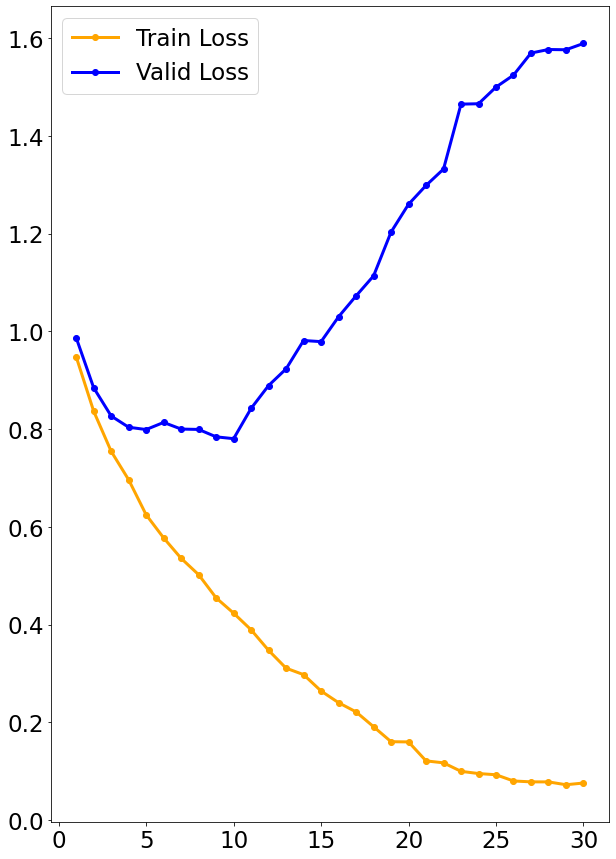

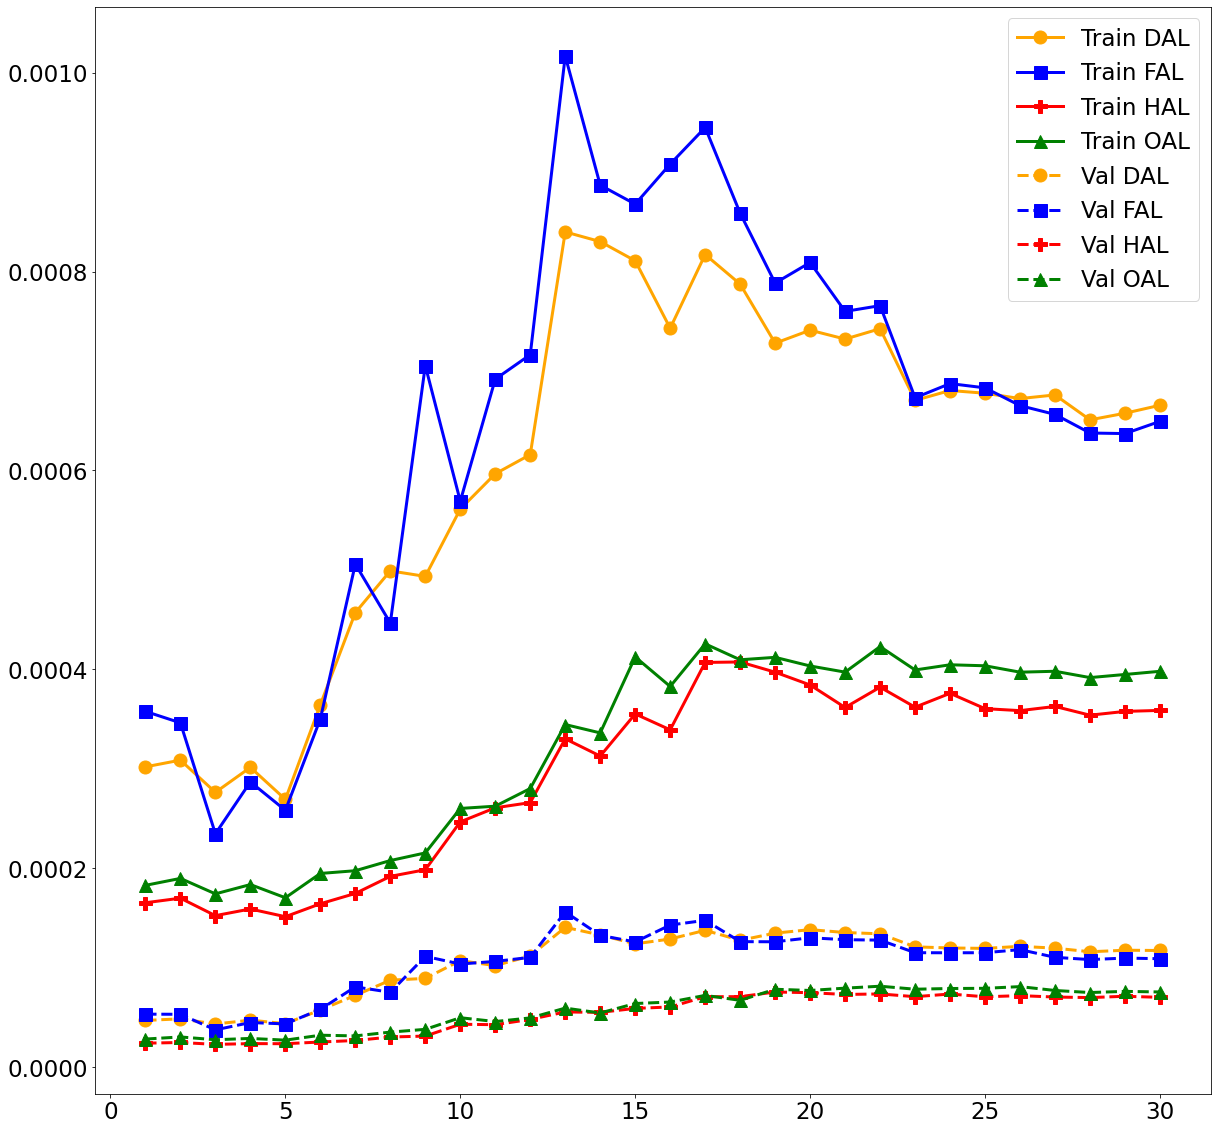

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


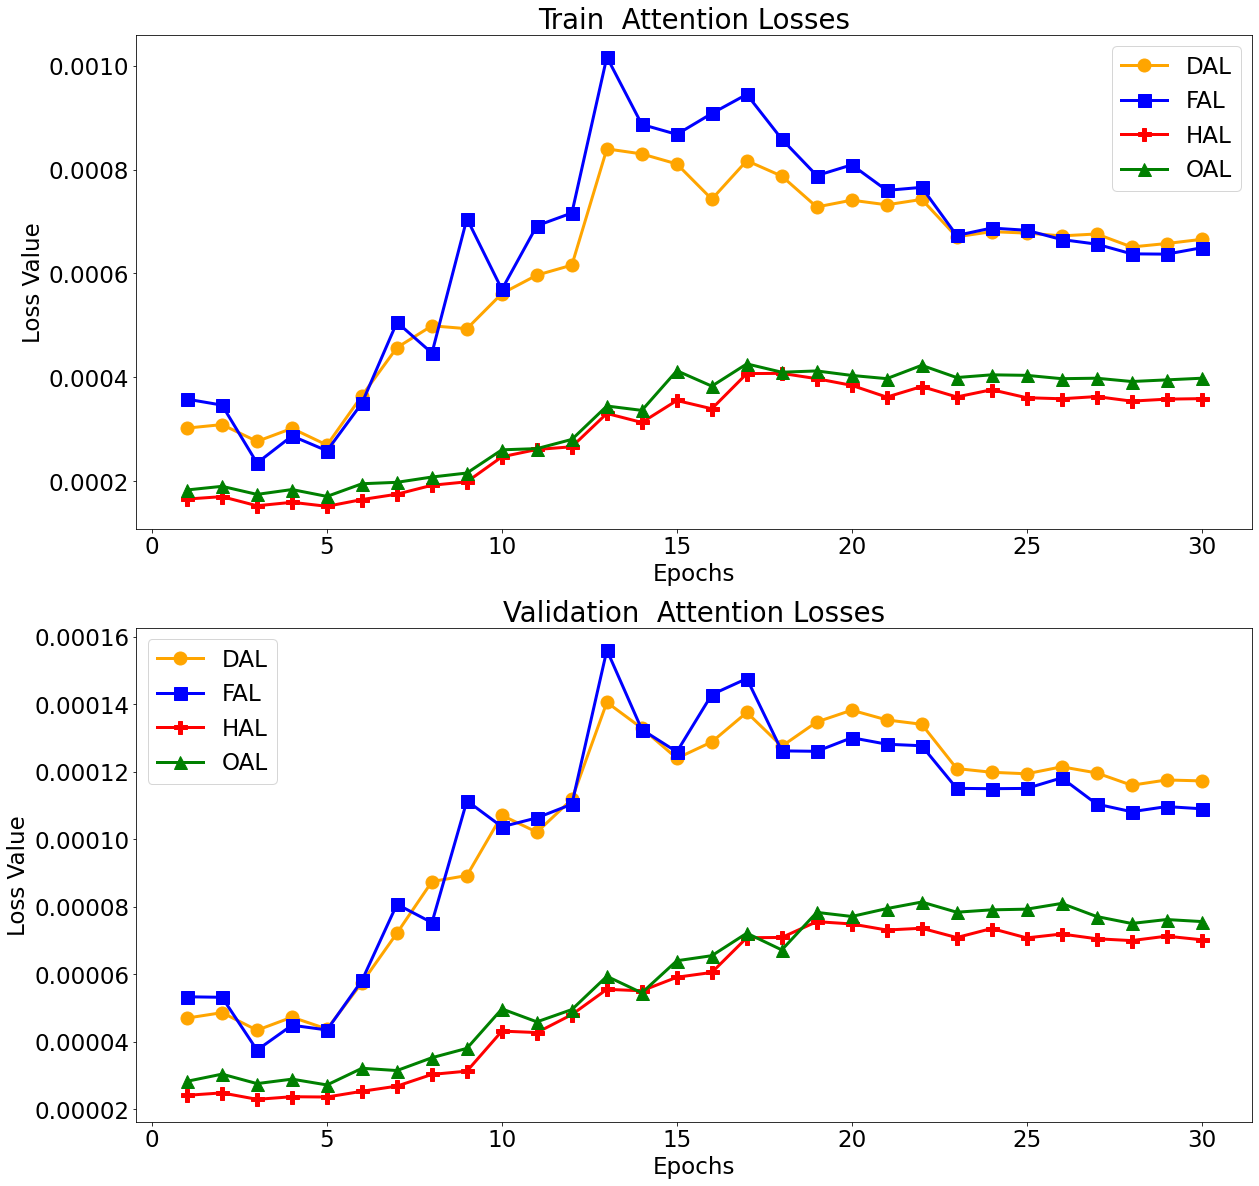

<ipython-input-60-0cfd5d1fc126>:237: ResourceWarning: unclosed file <_io.BufferedWriter name='Raw Text with Emoji Attn Losses.pkl'>
  pickle.dump(losses, open("Raw Text with Emoji Attn Losses.pkl", 'wb'))




------------------Evaluating on Test-----------------




 Test  Attention Loss

Defamation Supervised Attention Loss:  -16.375243464684008
Fake Supervised Attention Loss:        -7.651537628757709
Hate Supervised Attention Loss:        -11.852611660665398
Offensive Supervised Attention Loss:   -16.852755306886166
Classifier Supervised Attention Loss:  0.8799728118643468 


Total  Test  Loss -51.85217425287986


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4296
Fake       F1 Score:     0.7878
Hate       F1 Score:     0.5401
Offensive  F1 Score:     0.5735

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6147624124592007


               precision    recall  f1-score   support

           0       0.36      0.53      0.43       169
           1       0.77      0.81      0.79       334
           2       0.47      0.63      0.54       234
           3       0.61      0.54      0.57       219

   micro avg       0.56      0.66      0.61       956
   

In [64]:
if(config.LOAD_CHECKPOINT):
    checkpoint_path = config.MODEL_FOLDER + config.CHECKPOINT_PATH
    checkpoint      = torch.load(checkpoint_path)    
    print("\n\n------------Loaded Checkpoint-----------------\n\n", config.CHECKPOINT_PATH)

else: 
    checkpoint = None

best_model,checkpoint_path, losses = run(train_dataloader, val_dataloader, test_dataloader, config.MODEL_FOLDER, 'PreHBT + concat Attn + LEH +BCE+MSE - ',checkpoint=checkpoint)

print("\n\n------------------Evaluating on Test-----------------\n\n")
criterion_clf        = nn.BCEWithLogitsLoss()
# supervised_attn_loss = Supervised_Attention_Loss()   
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')
test_loss,val_f1_score,test_attn_losses  = check_accuracy(best_model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")


/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


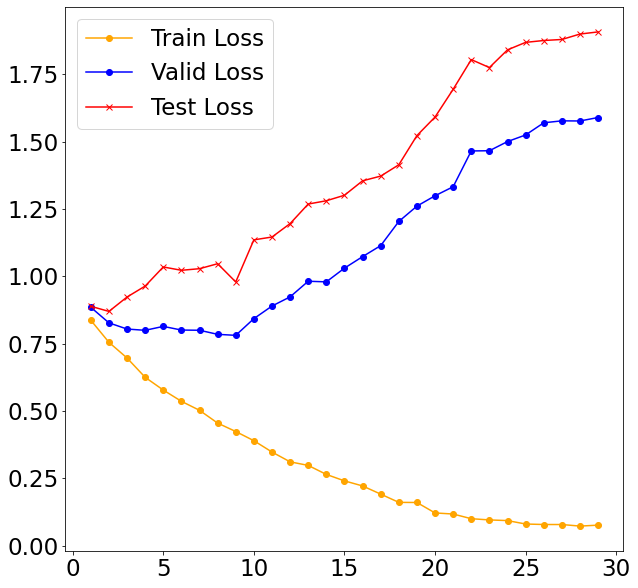

In [65]:
x = np.arange(1,len(losses[0]))
plt.figure(figsize=(10,10))
plt.plot(x,losses[0][1:], color='orange',label='Train Loss', marker = 'o')
plt.plot(x,losses[1][1:], color='blue',  label='Valid Loss', marker = 'o')
plt.plot(x,losses[2][1:], color='red',    label='Test Loss', marker = 'x')
plt.legend()
plt.show()

<h2>Coarse Grained Training from Scratch

In [66]:
config.NUM_LABELS       = 1
config.COARSE_GRAINED   = True
config.SERVER           = True
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = False

config.PERCENTAGE_DATA  = 100
config.LR               = 0.0001
config.EPOCHS           = 30

### Loss Hyperparameters
config.DEFAMATION_LOSS_LAMBDA = 4.74
config.FAKE_LOSS_LAMBDA       = 2.34
config.HATE_LOSS_LAMBDA       = 3.38
config.OFFENSIVE_LOSS_LAMBDA  = 3.64

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
torch.manual_seed(config.SEED)

# train_dataset = HindiHostilityDataset("Data/pkl_combined_fine_train.pkl")
train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

<ipython-input-32-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_train.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  5728  only


<ipython-input-32-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_valid.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  811  only


<ipython-input-32-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_test.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  1653  only


In [68]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=True)


Training Model:  PreHBT + concat Attn + LEH + BCE+MSE + Coarse -   




Epoch [1/30] Batch [1/358]: : 1it [00:00,  5.26it/s, Correct=9/16, Loss=0.7247, accuracy=56.2, f1_score=0.45]



-----------------------Training---------------------------




Epoch [1/30] Batch [358/358]: : 358it [01:18,  4.57it/s, Correct=5199/5728, Loss=0.2610, accuracy=90.8, f1_score=0.908]


Train loss for epoch  0  is:  0.2609550672786196


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0003062990720448209
Fake Supervised Attention Loss:        0.00033635446576511514
Hate Supervised Attention Loss:        0.00015717640635994453
Offensive Supervised Attention Loss:   0.0001681515397342602
Classifier Supervised Attention Loss:  0.19528024599955068 


Total  Train  Loss 0.19624822778762552

 Train  Coarse Grained Scores:  0.9291904875536973


               precision    recall  f1-score   support

         0.0       0.89      0.98      0.94      3050
         1.0       0.98      0.87      0.92      2678

    accuracy                           0.93      5728
   macro avg       0.94      0.93      0.93      5728
weighted avg       0.93      0.93      0.93      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Def

Epoch [2/30] Batch [1/358]: : 1it [00:00,  7.42it/s, Correct=14/16, Loss=0.2700, accuracy=87.5, f1_score=0.873]



--------------------Model Saved------------------




Epoch [2/30] Batch [358/358]: : 358it [01:18,  4.58it/s, Correct=5507/5728, Loss=0.1274, accuracy=96.1, f1_score=0.961]


Train loss for epoch  1  is:  0.12738575817569675


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00018626375529950378
Fake Supervised Attention Loss:        0.00016019875817543084
Hate Supervised Attention Loss:        0.00011151164443246839
Offensive Supervised Attention Loss:   0.00014575859255578684
Classifier Supervised Attention Loss:  0.05999309643088481 


Total  Train  Loss 0.06059682896027768

 Train  Coarse Grained Scores:  0.9834239081157453


               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3050
         1.0       0.97      0.99      0.98      2678

    accuracy                           0.98      5728
   macro avg       0.98      0.98      0.98      5728
weighted avg       0.98      0.98      0.98      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss



Epoch [3/30] Batch [1/358]: : 1it [00:00,  5.61it/s, Correct=15/16, Loss=0.1984, accuracy=93.8, f1_score=0.936]



--------------------Model Saved------------------




Epoch [3/30] Batch [358/358]: : 358it [01:16,  4.66it/s, Correct=5602/5728, Loss=0.0778, accuracy=97.8, f1_score=0.978]


Train loss for epoch  2  is:  0.07780353891189788


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00019008858916272884
Fake Supervised Attention Loss:        0.0001674378999796215
Hate Supervised Attention Loss:        0.00011261626214285345
Offensive Supervised Attention Loss:   0.00014392912832941388
Classifier Supervised Attention Loss:  0.0363381923398773 


Total  Train  Loss 0.03695226427656728

 Train  Coarse Grained Scores:  0.9924932710988676


               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3050
         1.0       0.99      0.99      0.99      2678

    accuracy                           0.99      5728
   macro avg       0.99      0.99      0.99      5728
weighted avg       0.99      0.99      0.99      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

De

Epoch [4/30] Batch [1/358]: : 1it [00:00,  6.41it/s, Correct=16/16, Loss=0.0075, accuracy=100, f1_score=1]



--------------------Model Saved------------------




Epoch [4/30] Batch [358/358]: : 358it [01:18,  4.54it/s, Correct=5642/5728, Loss=0.0551, accuracy=98.5, f1_score=0.985]


Train loss for epoch  3  is:  0.05512618264651665


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00015469145468149527
Fake Supervised Attention Loss:        0.00010582153411282458
Hate Supervised Attention Loss:        9.474887406492841e-05
Offensive Supervised Attention Loss:   0.00013298203303041615
Classifier Supervised Attention Loss:  0.020140573521555717 


Total  Train  Loss 0.020628817551821346

 Train  Coarse Grained Scores:  0.9965089153541633


               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      3050
         1.0       0.99      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss


Epoch [5/30] Batch [1/358]: : 1it [00:00,  6.13it/s, Correct=16/16, Loss=0.0050, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0001754869075456064
Fake Supervised Attention Loss:        0.00013087439749142498
Hate Supervised Attention Loss:        0.00010493581946320771
Offensive Supervised Attention Loss:   0.0001496452364825437
Classifier Supervised Attention Loss:  0.1366141497900781 


Total  Test  Loss 0.137175091611705

 Test  Coarse Grained Scores:  0.9552600886981836


               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96       873
         1.0       0.94      0.97      0.95       780

    accuracy                           0.96      1653
   macro avg       0.95      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [5/30] Batch [358/358]: : 358it [01:04,  5.58it/s, Correct=5679/5728, Loss=0.0331, accuracy=99.1, f1_score=0.991]


Train loss for epoch  4  is:  0.03305936668343925


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00014839227235941956
Fake Supervised Attention Loss:        9.879339527506293e-05
Hate Supervised Attention Loss:        9.105754444155845e-05
Offensive Supervised Attention Loss:   0.00012899521503712287
Classifier Supervised Attention Loss:  0.015981817229744566 


Total  Train  Loss 0.01644905544680871

 Train  Coarse Grained Scores:  0.9972068916347226


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

D

0it [00:00, ?it/s]



--------------------Model Saved------------------




Epoch [6/30] Batch [358/358]: : 358it [01:17,  4.63it/s, Correct=5702/5728, Loss=0.0241, accuracy=99.5, f1_score=0.995]


Train loss for epoch  5  is:  0.024087718337730053


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001431939953290161
Fake Supervised Attention Loss:        9.20039325577636e-05
Hate Supervised Attention Loss:        8.876887187072915e-05
Offensive Supervised Attention Loss:   0.0001253219547208837
Classifier Supervised Attention Loss:  0.020596718953144553 


Total  Train  Loss 0.02104600757983508

 Train  Coarse Grained Scores:  0.99493849439221


               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      3050
         1.0       0.99      1.00      0.99      2678

    accuracy                           0.99      5728
   macro avg       0.99      1.00      0.99      5728
weighted avg       0.99      0.99      0.99      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defam

Epoch [7/30] Batch [1/358]: : 1it [00:00,  6.06it/s, Correct=16/16, Loss=0.0057, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015278368741921723
Fake Supervised Attention Loss:        9.635126530611159e-05
Hate Supervised Attention Loss:        9.579851268881606e-05
Offensive Supervised Attention Loss:   0.00013331682512986073
Classifier Supervised Attention Loss:  0.18682823123750636 


Total  Test  Loss 0.1873064800411857

 Test  Coarse Grained Scores:  0.9601042131294505


               precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       873
         1.0       0.93      0.99      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [7/30] Batch [358/358]: : 358it [01:17,  4.63it/s, Correct=5681/5728, Loss=0.0311, accuracy=99.2, f1_score=0.992]


Train loss for epoch  6  is:  0.031054642039426608


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001475514950052152
Fake Supervised Attention Loss:        0.00010479764697179266
Hate Supervised Attention Loss:        8.901535539115166e-05
Offensive Supervised Attention Loss:   0.0001293402372817715
Classifier Supervised Attention Loss:  0.010091543853524865 


Total  Train  Loss 0.010562248547514641

 Train  Coarse Grained Scores:  0.9982543072717016


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss



0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0001733450638581556
Fake Supervised Attention Loss:        0.0001420939199442728
Hate Supervised Attention Loss:        0.00010017674649589025
Offensive Supervised Attention Loss:   0.00015040396065824798
Classifier Supervised Attention Loss:  0.151901132220071 


Total  Test  Loss 0.15246715152954074

 Test  Coarse Grained Scores:  0.9594765888670767


               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       873
         1.0       0.95      0.96      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [8/30] Batch [358/358]: : 358it [01:18,  4.58it/s, Correct=5700/5728, Loss=0.0200, accuracy=99.5, f1_score=0.995]


Train loss for epoch  7  is:  0.0199640755178719


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013997947969983217
Fake Supervised Attention Loss:        9.067575744142765e-05
Hate Supervised Attention Loss:        8.872981181259458e-05
Offensive Supervised Attention Loss:   0.00012477054958380608
Classifier Supervised Attention Loss:  0.007244331098172044 


Total  Train  Loss 0.0076884867440695824

 Train  Coarse Grained Scores:  0.9993016917937234


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss



Epoch [9/30] Batch [1/358]: : 1it [00:00,  5.59it/s, Correct=16/16, Loss=0.0023, accuracy=100, f1_score=1]



--------------------Model Saved------------------




Epoch [9/30] Batch [358/358]: : 358it [01:17,  4.64it/s, Correct=5719/5728, Loss=0.0094, accuracy=99.8, f1_score=0.998]


Train loss for epoch  8  is:  0.009443363400797917


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.000143165847212664
Fake Supervised Attention Loss:        9.453350819693073e-05
Hate Supervised Attention Loss:        8.926134539957764e-05
Offensive Supervised Attention Loss:   0.00012759061475647513
Classifier Supervised Attention Loss:  0.00694224404279395 


Total  Train  Loss 0.007396795199637681

 Train  Coarse Grained Scores:  0.9987779190086723


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

De

Epoch [10/30] Batch [1/358]: : 1it [00:00,  6.36it/s, Correct=16/16, Loss=0.0013, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00017276863218215174
Fake Supervised Attention Loss:        0.0001296289054926092
Hate Supervised Attention Loss:        0.00010095500575971528
Offensive Supervised Attention Loss:   0.00014495527229708107
Classifier Supervised Attention Loss:  0.1888310027643456 


Total  Test  Loss 0.18937930938465378

 Test  Coarse Grained Scores:  0.9569870240309499


               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       873
         1.0       0.97      0.93      0.95       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [10/30] Batch [358/358]: : 358it [01:17,  4.59it/s, Correct=5692/5728, Loss=0.0218, accuracy=99.4, f1_score=0.994]


Train loss for epoch  9  is:  0.021778961107675923


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00014408474946443737
Fake Supervised Attention Loss:        9.759982231279323e-05
Hate Supervised Attention Loss:        8.713870231864275e-05
Offensive Supervised Attention Loss:   0.00012850329913029852
Classifier Supervised Attention Loss:  0.007410422979474234 


Total  Train  Loss 0.007867749521246066

 Train  Coarse Grained Scores:  0.9986034148747751


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss


Epoch [11/30] Batch [1/358]: : 1it [00:00,  7.67it/s, Correct=16/16, Loss=0.0032, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00017802407693055176
Fake Supervised Attention Loss:        0.00014646981065197907
Hate Supervised Attention Loss:        9.802770783153392e-05
Offensive Supervised Attention Loss:   0.00014937290914321456
Classifier Supervised Attention Loss:  0.16188646136064422 


Total  Test  Loss 0.16245835524079247

 Test  Coarse Grained Scores:  0.9600725952813067


               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       873
         1.0       0.96      0.96      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [11/30] Batch [358/358]: : 358it [01:02,  5.69it/s, Correct=5714/5728, Loss=0.0102, accuracy=99.8, f1_score=0.998]


Train loss for epoch  10  is:  0.010193059327895103


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013400730207853003
Fake Supervised Attention Loss:        7.932470282750282e-05
Hate Supervised Attention Loss:        8.439056715939722e-05
Offensive Supervised Attention Loss:   0.00012209901837454638
Classifier Supervised Attention Loss:  0.004424202477272637 


Total  Train  Loss 0.0048440242803710195

 Train  Coarse Grained Scores:  0.9994762629304311


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Los

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015627567607365427
Fake Supervised Attention Loss:        0.00010655192420927053
Hate Supervised Attention Loss:        9.45438880944493e-05
Offensive Supervised Attention Loss:   0.00013621752754611053
Classifier Supervised Attention Loss:  0.1744560582743501 


Total  Test  Loss 0.17494964825947626

 Test  Coarse Grained Scores:  0.9618936320192252


               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       873
         1.0       0.96      0.96      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [12/30] Batch [358/358]: : 358it [01:16,  4.67it/s, Correct=5715/5728, Loss=0.0106, accuracy=99.8, f1_score=0.998]


Train loss for epoch  11  is:  0.010574253076653637


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00014166984745092291
Fake Supervised Attention Loss:        9.44418580753061e-05
Hate Supervised Attention Loss:        8.665931564634612e-05
Offensive Supervised Attention Loss:   0.000124427138824093
Classifier Supervised Attention Loss:  0.004619528825476755 


Total  Train  Loss 0.005066726912481596

 Train  Coarse Grained Scores:  0.9993016917937234


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

D

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0001639989625332069
Fake Supervised Attention Loss:        0.0001239637827166007
Hate Supervised Attention Loss:        9.561038481479045e-05
Offensive Supervised Attention Loss:   0.0001403359352217684
Classifier Supervised Attention Loss:  0.1511996658227872 


Total  Test  Loss 0.15172357449885637

 Test  Coarse Grained Scores:  0.963120396970735


               precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       873
         1.0       0.95      0.98      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [13/30] Batch [358/358]: : 358it [01:16,  4.67it/s, Correct=5725/5728, Loss=0.0048, accuracy=99.9, f1_score=0.999]


Train loss for epoch  12  is:  0.00481304623818743


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013501661424310452
Fake Supervised Attention Loss:        8.142010752310364e-05
Hate Supervised Attention Loss:        8.519593747812947e-05
Offensive Supervised Attention Loss:   0.00012180695031025215
Classifier Supervised Attention Loss:  0.001753025334757654 


Total  Train  Loss 0.0021764648838102684

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015802541156552678
Fake Supervised Attention Loss:        0.00010784205831441789
Hate Supervised Attention Loss:        9.493841187122599e-05
Offensive Supervised Attention Loss:   0.0001382670343173231
Classifier Supervised Attention Loss:  0.18869186588688955 


Total  Test  Loss 0.1891909375173362

 Test  Coarse Grained Scores:  0.9618714570177904


               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       873
         1.0       0.97      0.95      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [14/30] Batch [358/358]: : 358it [01:17,  4.63it/s, Correct=5727/5728, Loss=0.0024, accuracy=100, f1_score=1]


Train loss for epoch  13  is:  0.002395417966522854


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013475900677438206
Fake Supervised Attention Loss:        8.167646385290893e-05
Hate Supervised Attention Loss:        8.542081735268562e-05
Offensive Supervised Attention Loss:   0.00012227213196582437
Classifier Supervised Attention Loss:  0.002052714280194249 


Total  Train  Loss 0.002476842638951279

 Train  Coarse Grained Scores:  0.9996508379888268


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Epoch [15/30] Batch [1/358]: : 1it [00:00,  6.54it/s, Correct=16/16, Loss=0.0009, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015732018754079034
Fake Supervised Attention Loss:        0.00010797522735629167
Hate Supervised Attention Loss:        9.444411731237777e-05
Offensive Supervised Attention Loss:   0.00013952774997505918
Classifier Supervised Attention Loss:  0.25163771416317526 


Total  Test  Loss 0.25213698084385566

 Test  Coarse Grained Scores:  0.953944367194435


               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       873
         1.0       0.97      0.93      0.95       780

    accuracy                           0.95      1653
   macro avg       0.96      0.95      0.95      1653
weighted avg       0.95      0.95      0.95      1653



Epoch [15/30] Batch [358/358]: : 358it [01:03,  5.67it/s, Correct=5727/5728, Loss=0.0024, accuracy=100, f1_score=1]     


Train loss for epoch  14  is:  0.0023991950557049487


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013586776604260987
Fake Supervised Attention Loss:        8.365801016707992e-05
Hate Supervised Attention Loss:        8.589680501509527e-05
Offensive Supervised Attention Loss:   0.00012286383101792892
Classifier Supervised Attention Loss:  0.002669595409874569 


Total  Train  Loss 0.0030978817735634765

 Train  Coarse Grained Scores:  0.9993016599891429


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Lo

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015858431660245313
Fake Supervised Attention Loss:        0.00011149254097745138
Hate Supervised Attention Loss:        9.476552874502884e-05
Offensive Supervised Attention Loss:   0.00013936951793976521
Classifier Supervised Attention Loss:  0.31603674397047143 


Total  Test  Loss 0.31654095245287933

 Test  Coarse Grained Scores:  0.9453859130405491


               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       873
         1.0       0.98      0.91      0.94       780

    accuracy                           0.95      1653
   macro avg       0.95      0.94      0.95      1653
weighted avg       0.95      0.95      0.95      1653



Epoch [16/30] Batch [358/358]: : 358it [01:14,  4.84it/s, Correct=5711/5728, Loss=0.0096, accuracy=99.7, f1_score=0.997]


Train loss for epoch  15  is:  0.009618455321689309


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001357589335682291
Fake Supervised Attention Loss:        8.396687310874896e-05
Hate Supervised Attention Loss:        8.469277023048865e-05
Offensive Supervised Attention Loss:   0.00012391885423642751
Classifier Supervised Attention Loss:  0.0041984504116969 


Total  Train  Loss 0.004626787951484052

 Train  Coarse Grained Scores:  0.9991270649127642


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

D

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015892806427683155
Fake Supervised Attention Loss:        0.00011286183872016406
Hate Supervised Attention Loss:        9.382640185776837e-05
Offensive Supervised Attention Loss:   0.00014197163849950393
Classifier Supervised Attention Loss:  0.2414402426701809 


Total  Test  Loss 0.2419478294905275

 Test  Coarse Grained Scores:  0.9478646967900398


               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       873
         1.0       0.97      0.92      0.94       780

    accuracy                           0.95      1653
   macro avg       0.95      0.95      0.95      1653
weighted avg       0.95      0.95      0.95      1653



Epoch [17/30] Batch [358/358]: : 358it [01:17,  4.62it/s, Correct=5725/5728, Loss=0.0034, accuracy=99.9, f1_score=0.999]


Train loss for epoch  16  is:  0.0034208450158771816


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001331744525659765
Fake Supervised Attention Loss:        7.766205432201095e-05
Hate Supervised Attention Loss:        8.371682860535925e-05
Offensive Supervised Attention Loss:   0.00012135297818257032
Classifier Supervised Attention Loss:  0.0016741877051516484 


Total  Train  Loss 0.0020900939521477325

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Lo

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015588830285371216
Fake Supervised Attention Loss:        0.00010473241099589354
Hate Supervised Attention Loss:        9.334270848285084e-05
Offensive Supervised Attention Loss:   0.00013888654719161977
Classifier Supervised Attention Loss:  0.21083347095247099 


Total  Test  Loss 0.2113263232341314

 Test  Coarse Grained Scores:  0.959443500614001


               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       873
         1.0       0.97      0.95      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [18/30] Batch [358/358]: : 358it [01:18,  4.53it/s, Correct=5721/5728, Loss=0.0059, accuracy=99.9, f1_score=0.999]


Train loss for epoch  17  is:  0.005907876351516558


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013306569448653455
Fake Supervised Attention Loss:        7.644336896273115e-05
Hate Supervised Attention Loss:        8.321618167530438e-05
Offensive Supervised Attention Loss:   0.0001216557177059516
Classifier Supervised Attention Loss:  0.0016339096764365001 


Total  Train  Loss 0.0020482906668158195

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Los

Epoch [19/30] Batch [1/358]: : 1it [00:00,  7.18it/s, Correct=16/16, Loss=0.0006, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015118743489333258
Fake Supervised Attention Loss:        9.55232779097059e-05
Hate Supervised Attention Loss:        9.156945044196617e-05
Offensive Supervised Attention Loss:   0.00013790508906227986
Classifier Supervised Attention Loss:  0.22056911504114396 


Total  Test  Loss 0.22104530194281743

 Test  Coarse Grained Scores:  0.9545880064862374


               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       873
         1.0       0.96      0.94      0.95       780

    accuracy                           0.95      1653
   macro avg       0.96      0.95      0.95      1653
weighted avg       0.95      0.95      0.95      1653



Epoch [19/30] Batch [358/358]: : 358it [01:16,  4.70it/s, Correct=5719/5728, Loss=0.0061, accuracy=99.8, f1_score=0.998]


Train loss for epoch  18  is:  0.00610952800298799


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001369189564165072
Fake Supervised Attention Loss:        8.17009338611087e-05
Hate Supervised Attention Loss:        8.48394524666991e-05
Offensive Supervised Attention Loss:   0.0001231587283899131
Classifier Supervised Attention Loss:  0.004011099885307921 


Total  Train  Loss 0.004437718014040957

 Train  Coarse Grained Scores:  0.9993016599891429


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Def

Epoch [20/30] Batch [1/358]: : 1it [00:00,  5.88it/s, Correct=16/16, Loss=0.0010, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015752964194129724
Fake Supervised Attention Loss:        0.00010792697583383417
Hate Supervised Attention Loss:        9.398728089081482e-05
Offensive Supervised Attention Loss:   0.00014008247060141564
Classifier Supervised Attention Loss:  0.21032176630950955 


Total  Test  Loss 0.21082129319984233

 Test  Coarse Grained Scores:  0.9563978436740594


               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       873
         1.0       0.97      0.94      0.95       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [20/30] Batch [358/358]: : 358it [01:16,  4.69it/s, Correct=5727/5728, Loss=0.0024, accuracy=100, f1_score=1]     


Train loss for epoch  19  is:  0.0024016641628962303


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013300923600109355
Fake Supervised Attention Loss:        7.623974603669329e-05
Hate Supervised Attention Loss:        8.314630149115093e-05
Offensive Supervised Attention Loss:   0.00012094150632535726
Classifier Supervised Attention Loss:  0.001323170131852027 


Total  Train  Loss 0.0017365069418310516

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Lo

Epoch [21/30] Batch [1/358]: : 1it [00:00,  5.18it/s, Correct=16/16, Loss=0.0021, accuracy=100, f1_score=1]



--------------------Model Saved------------------




Epoch [21/30] Batch [358/358]: : 358it [01:18,  4.57it/s, Correct=5727/5728, Loss=0.0021, accuracy=100, f1_score=1]     


Train loss for epoch  20  is:  0.0020845763633410086


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001324687323718109
Fake Supervised Attention Loss:        7.524685206915397e-05
Hate Supervised Attention Loss:        8.291935941601187e-05
Offensive Supervised Attention Loss:   0.0001207698019389586
Classifier Supervised Attention Loss:  0.0011583347024406467 


Total  Train  Loss 0.0015697393925046268

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Los

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0001516909943375839
Fake Supervised Attention Loss:        9.800781512694813e-05
Hate Supervised Attention Loss:        9.129781326009833e-05
Offensive Supervised Attention Loss:   0.00013618894674436883
Classifier Supervised Attention Loss:  0.18802676607615118 


Total  Test  Loss 0.18850395249655078

 Test  Coarse Grained Scores:  0.9655184060187553


               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       873
         1.0       0.96      0.96      0.96       780

    accuracy                           0.97      1653
   macro avg       0.97      0.97      0.97      1653
weighted avg       0.97      0.97      0.97      1653



Epoch [22/30] Batch [358/358]: : 358it [01:16,  4.65it/s, Correct=5727/5728, Loss=0.0020, accuracy=100, f1_score=1]     


Train loss for epoch  21  is:  0.00195639764321981


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013236331922273582
Fake Supervised Attention Loss:        7.495656109567182e-05
Hate Supervised Attention Loss:        8.292189592839606e-05
Offensive Supervised Attention Loss:   0.00012064305661309513
Classifier Supervised Attention Loss:  0.0008436793707727062 


Total  Train  Loss 0.0012545642073431402

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Los

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015217744879219723
Fake Supervised Attention Loss:        9.716523810311631e-05
Hate Supervised Attention Loss:        9.145396419171446e-05
Offensive Supervised Attention Loss:   0.00013599351198046445
Classifier Supervised Attention Loss:  0.1965608591279026 


Total  Test  Loss 0.1970376495664823

 Test  Coarse Grained Scores:  0.9649072810561107


               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       873
         1.0       0.97      0.96      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [23/30] Batch [358/358]: : 358it [01:14,  4.80it/s, Correct=5726/5728, Loss=0.0021, accuracy=100, f1_score=1]     


Train loss for epoch  22  is:  0.002064626855943508


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001317323827528495
Fake Supervised Attention Loss:        7.481946461112842e-05
Hate Supervised Attention Loss:        8.268689305140714e-05
Offensive Supervised Attention Loss:   0.00012033770954589484
Classifier Supervised Attention Loss:  0.0009293521171005335 


Total  Train  Loss 0.0013389286206151989

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Los

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015201906628625202
Fake Supervised Attention Loss:        9.681279687811189e-05
Hate Supervised Attention Loss:        9.132507401318435e-05
Offensive Supervised Attention Loss:   0.00013422713791652103
Classifier Supervised Attention Loss:  0.21036052500823224 


Total  Test  Loss 0.21083490590787662

 Test  Coarse Grained Scores:  0.9655228099221563


               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       873
         1.0       0.96      0.97      0.96       780

    accuracy                           0.97      1653
   macro avg       0.97      0.97      0.97      1653
weighted avg       0.97      0.97      0.97      1653



Epoch [24/30] Batch [358/358]: : 358it [01:17,  4.61it/s, Correct=5725/5728, Loss=0.0030, accuracy=99.9, f1_score=0.999]


Train loss for epoch  23  is:  0.003035577720059758


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013230179508979896
Fake Supervised Attention Loss:        7.528114906862905e-05
Hate Supervised Attention Loss:        8.282967248727526e-05
Offensive Supervised Attention Loss:   0.00012055903051580631
Classifier Supervised Attention Loss:  0.0005279877872626407 


Total  Train  Loss 0.0009389594122481288

 Train  Coarse Grained Scores:  0.9998254209768105


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Lo

Epoch [25/30] Batch [1/358]: : 1it [00:00,  5.48it/s, Correct=16/16, Loss=0.0011, accuracy=100, f1_score=1]



--------------------Model Saved------------------




Epoch [25/30] Batch [358/358]: : 358it [01:16,  4.70it/s, Correct=5727/5728, Loss=0.0013, accuracy=100, f1_score=1]


Train loss for epoch  24  is:  0.0012865324219163278


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013261390131894256
Fake Supervised Attention Loss:        7.546795118099274e-05
Hate Supervised Attention Loss:        8.313945826161438e-05
Offensive Supervised Attention Loss:   0.0001204267348313613
Classifier Supervised Attention Loss:  0.00021674775545670348 


Total  Train  Loss 0.000628395791782727

 Train  Coarse Grained Scores:  1.0


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defamation 

0it [00:00, ?it/s]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015466956013439738
Fake Supervised Attention Loss:        9.956061495358883e-05
Hate Supervised Attention Loss:        9.240887343821669e-05
Offensive Supervised Attention Loss:   0.0001358771281960659
Classifier Supervised Attention Loss:  0.2312960157355869 


Total  Test  Loss 0.23177853222240138

 Test  Coarse Grained Scores:  0.9570222170685682


               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       873
         1.0       0.96      0.94      0.95       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [26/30] Batch [358/358]: : 358it [01:03,  5.61it/s, Correct=5727/5728, Loss=0.0009, accuracy=100, f1_score=1]


Train loss for epoch  25  is:  0.000926007044598507


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013221613739757994
Fake Supervised Attention Loss:        7.50906480427361e-05
Hate Supervised Attention Loss:        8.300283073662302e-05
Offensive Supervised Attention Loss:   0.00012038103420573414
Classifier Supervised Attention Loss:  0.00012896758460800045 


Total  Train  Loss 0.0005396582223130286

 Train  Coarse Grained Scores:  1.0


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defamation 

Epoch [27/30] Batch [1/358]: : 1it [00:00,  7.01it/s, Correct=16/16, Loss=0.0005, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015294753561612687
Fake Supervised Attention Loss:        9.77954240443068e-05
Hate Supervised Attention Loss:        9.15701133226321e-05
Offensive Supervised Attention Loss:   0.00013537964577643342
Classifier Supervised Attention Loss:  0.23421519087791098 


Total  Test  Loss 0.23469288507840247

 Test  Coarse Grained Scores:  0.9582401672099609


               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       873
         1.0       0.96      0.95      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [27/30] Batch [358/358]: : 358it [01:05,  5.49it/s, Correct=5728/5728, Loss=0.0007, accuracy=100, f1_score=1]


Train loss for epoch  26  is:  0.0007162686145842314


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.00013133934159754952
Fake Supervised Attention Loss:        7.486218561901013e-05
Hate Supervised Attention Loss:        8.26116733066795e-05
Offensive Supervised Attention Loss:   0.00012021268144500585
Classifier Supervised Attention Loss:  5.63496207950413e-05 


Total  Train  Loss 0.00046537549086318313

 Train  Coarse Grained Scores:  1.0


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defamation 

Epoch [28/30] Batch [1/358]: : 1it [00:00,  6.53it/s, Correct=16/16, Loss=0.0005, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015111036846834528
Fake Supervised Attention Loss:        9.681921840638102e-05
Hate Supervised Attention Loss:        9.063200585160298e-05
Offensive Supervised Attention Loss:   0.00013399730299170192
Classifier Supervised Attention Loss:  0.21785239708238946 


Total  Test  Loss 0.218324956185265

 Test  Coarse Grained Scores:  0.9661286920564722


               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       873
         1.0       0.96      0.97      0.96       780

    accuracy                           0.97      1653
   macro avg       0.97      0.97      0.97      1653
weighted avg       0.97      0.97      0.97      1653



Epoch [28/30] Batch [358/358]: : 358it [01:05,  5.49it/s, Correct=5728/5728, Loss=0.0005, accuracy=100, f1_score=1]


Train loss for epoch  27  is:  0.0005306735220683905


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001313721332923435
Fake Supervised Attention Loss:        7.475229041866648e-05
Hate Supervised Attention Loss:        8.265922494313871e-05
Offensive Supervised Attention Loss:   0.00012023707529023957
Classifier Supervised Attention Loss:  5.276445168094559e-05 


Total  Train  Loss 0.0004617851630748151

 Train  Coarse Grained Scores:  1.0


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defamation 

Epoch [29/30] Batch [1/358]: : 1it [00:00,  7.54it/s, Correct=16/16, Loss=0.0006, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015169878034402456
Fake Supervised Attention Loss:        9.737518435485981e-05
Hate Supervised Attention Loss:        9.126254981765665e-05
Offensive Supervised Attention Loss:   0.00013446962423131482
Classifier Supervised Attention Loss:  0.22982978202291912 


Total  Test  Loss 0.23030458831943598

 Test  Coarse Grained Scores:  0.9606704794338893


               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       873
         1.0       0.96      0.96      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [29/30] Batch [358/358]: : 358it [00:59,  6.06it/s, Correct=5728/5728, Loss=0.0005, accuracy=100, f1_score=1]


Train loss for epoch  28  is:  0.0005204780436187265


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.000131374482187911
Fake Supervised Attention Loss:        7.470384551604113e-05
Hate Supervised Attention Loss:        8.26767154709596e-05
Offensive Supervised Attention Loss:   0.0001202416556727216
Classifier Supervised Attention Loss:  5.035549872328837e-05 


Total  Train  Loss 0.0004593521866631335

 Train  Coarse Grained Scores:  1.0


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defamation Sup

Epoch [30/30] Batch [1/358]: : 1it [00:00,  6.59it/s, Correct=16/16, Loss=0.0004, accuracy=100, f1_score=1]



 Test  Attention Loss

Defamation Supervised Attention Loss:  0.00015211426927460426
Fake Supervised Attention Loss:        9.78353965547285e-05
Hate Supervised Attention Loss:        9.155347462183274e-05
Offensive Supervised Attention Loss:   0.00013621525854817335
Classifier Supervised Attention Loss:  0.24032724827978968 


Total  Test  Loss 0.24080496708568086

 Test  Coarse Grained Scores:  0.9594539650067319


               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       873
         1.0       0.96      0.95      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



Epoch [30/30] Batch [358/358]: : 358it [00:54,  6.55it/s, Correct=5728/5728, Loss=0.0005, accuracy=100, f1_score=1]


Train loss for epoch  29  is:  0.0005164203500991698


Train Results

 ************************************************************ 




 Train  Attention Loss

Defamation Supervised Attention Loss:  0.0001313961983813079
Fake Supervised Attention Loss:        7.469920046116904e-05
Hate Supervised Attention Loss:        8.268792323290572e-05
Offensive Supervised Attention Loss:   0.00012024844887715348
Classifier Supervised Attention Loss:  5.008887683542825e-05 


Total  Train  Loss 0.000459120636100246

 Train  Coarse Grained Scores:  1.0


               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3050
         1.0       1.00      1.00      1.00      2678

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728



Val Results

 ************************************************************ 




 Validation  Attention Loss

Defamation S

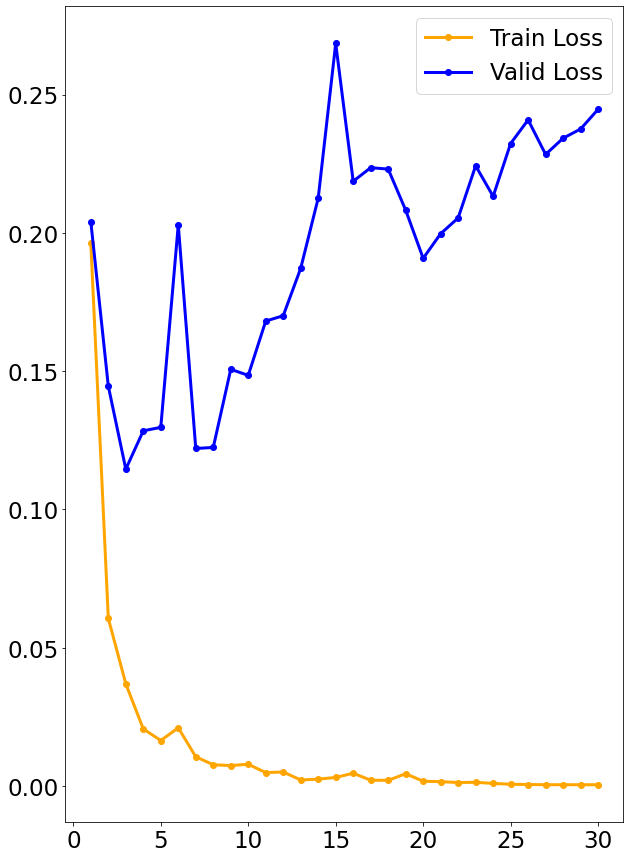

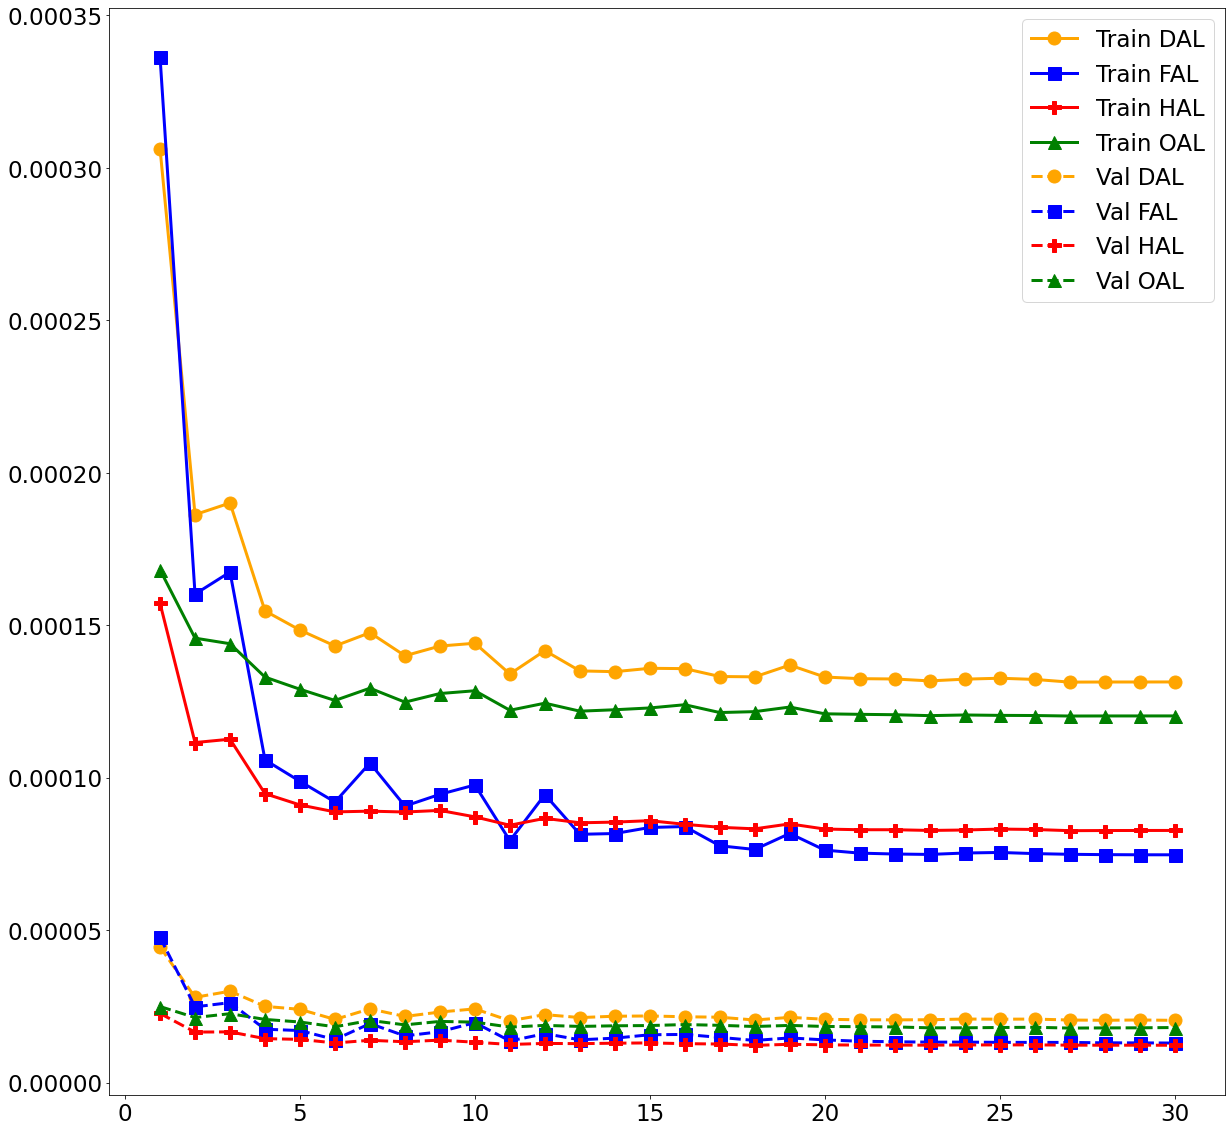

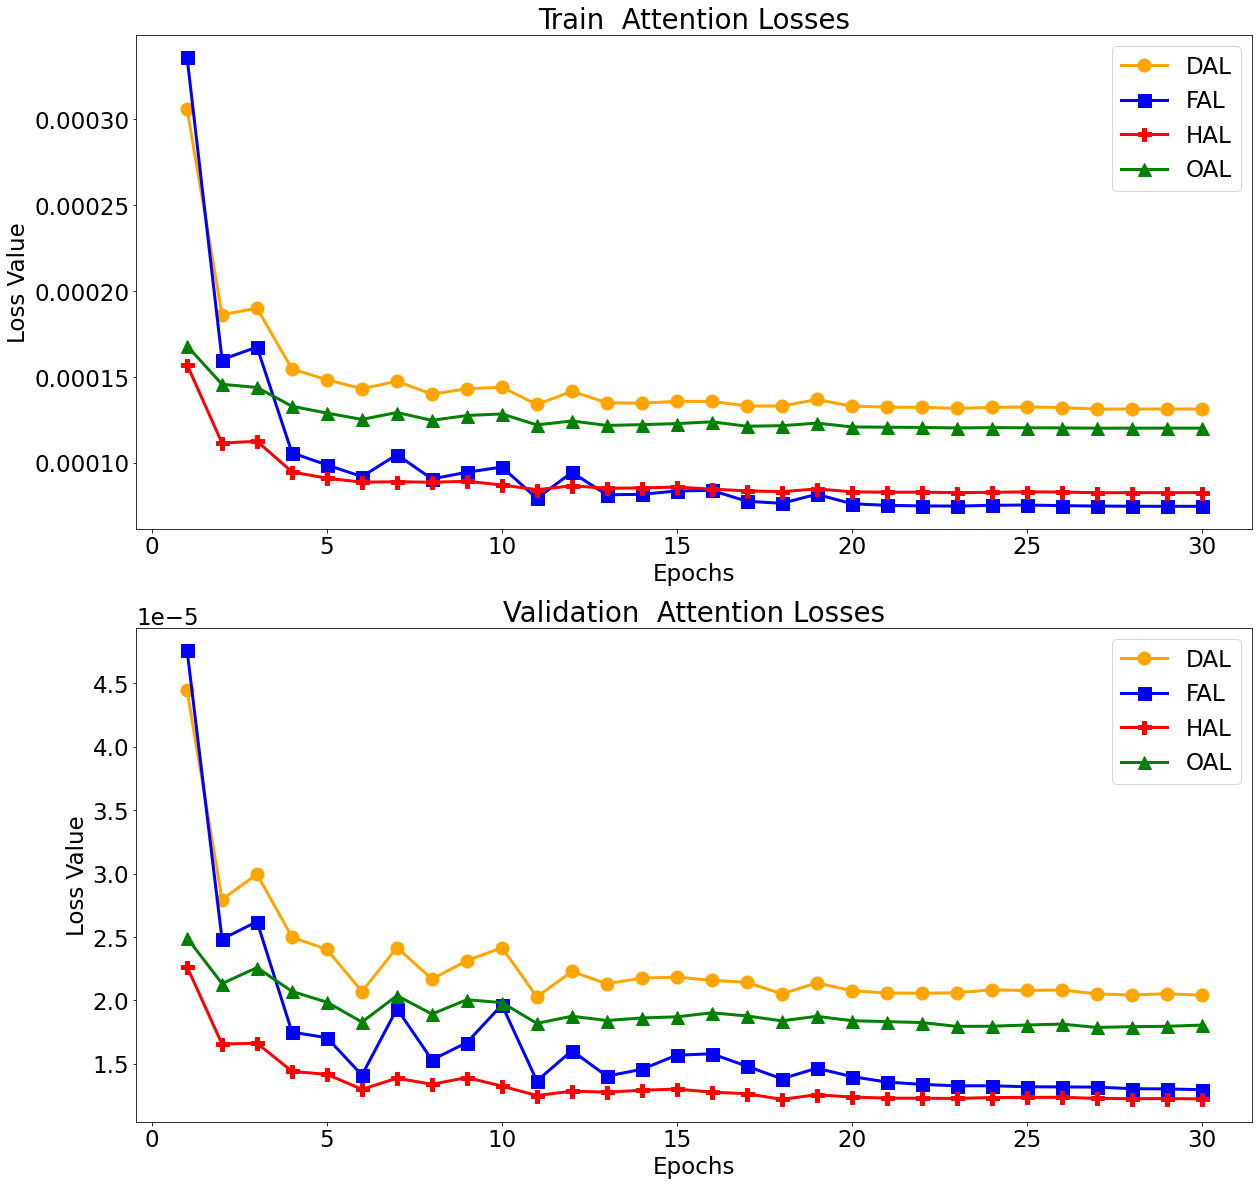

<ipython-input-60-0cfd5d1fc126>:237: ResourceWarning: unclosed file <_io.BufferedWriter name='Raw Text with Emoji Attn Losses.pkl'>
  pickle.dump(losses, open("Raw Text with Emoji Attn Losses.pkl", 'wb'))




------------------Evaluating on Test-----------------




 Test  Attention Loss

Defamation Supervised Attention Loss:  -18.064655375526495
Fake Supervised Attention Loss:        -8.892424412369726
Hate Supervised Attention Loss:        -12.887902924418446
Offensive Supervised Attention Loss:   -18.076725017336702
Classifier Supervised Attention Loss:  0.22519890671016513 


Total  Test  Loss -57.696507087120644

 Test  Coarse Grained Scores:  0.9594539650067319


               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       873
         1.0       0.96      0.95      0.96       780

    accuracy                           0.96      1653
   macro avg       0.96      0.96      0.96      1653
weighted avg       0.96      0.96      0.96      1653



In [69]:
if(config.LOAD_CHECKPOINT):
    checkpoint_path = config.MODEL_FOLDER + config.CHECKPOINT_PATH
    checkpoint      = torch.load(checkpoint_path)    
    print("\n\n------------Loaded Checkpoint-----------------\n\n", config.CHECKPOINT_PATH)

else: 
    checkpoint = None

best_coarse_model,checkpoint_path, losses = run(train_dataloader, val_dataloader, test_dataloader, config.MODEL_FOLDER, 'PreHBT + concat Attn + LEH + BCE+MSE + Coarse -  ',checkpoint=checkpoint)

print("\n\n------------------Evaluating on Test-----------------\n\n")
criterion_clf        = nn.BCEWithLogitsLoss()
# supervised_attn_loss = Supervised_Attention_Loss()   
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')
test_loss,val_f1_score,test_attn_losses  = check_accuracy(best_coarse_model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")


<h3> Evaluating Attentions

In [70]:
best_model    = BaseModel2()
initial_model = BaseModel2()

best_model.to(config.DEVICE)

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BaseModel2(
  (bert_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(39628, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=256, out_f

In [71]:
config.CHECKPOINT_PATH = "PreHBT + concat Attn (no Attention Tuning) -   F1 - 0.6513909224256432 Epoch 3.pt"
checkpoint_path = config.MODEL_FOLDER + config.CHECKPOINT_PATH
checkpoint      = torch.load(checkpoint_path)

FileNotFoundError: [Errno 2] No such file or directory: 'Final Experiments/HindiBERT/4LSTM + 4MHA/BCE + MSE/PreHBT + concat Attn (no Attention Tuning) -   F1 - 0.6513909224256432 Epoch 3.pt'

In [ ]:
print("\n\n------------------- Loading Checkpoint-----------------------\n\n")
warnings.filterwarnings("ignore")
best_model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
max_val_f1_score = checkpoint['val_f1_score']
warnings.filterwarnings("default")

In [ ]:
config.NUM_LABELS       = 4
config.COARSE_GRAINED   = False
config.SERVER           = True
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = False

config.PERCENTAGE_DATA  = 100
config.LR               = 0.0001
config.EPOCHS           = 15

### Loss Hyperparameters
config.DEFAMATION_LOSS_LAMBDA = 4.74
config.FAKE_LOSS_LAMBDA       = 2.34
config.HATE_LOSS_LAMBDA       = 3.38
config.OFFENSIVE_LOSS_LAMBDA  = 3.64

In [ ]:
torch.manual_seed(config.SEED)

train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

In [ ]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=False)


In [ ]:
class Supervised_Attention_Loss(nn.Module):
    def __init__(self):
        super(Supervised_Attention_Loss,self).__init__()
        
    def forward(self, targets, outputs):
        outputs = torch.log_softmax(outputs, dim=1)
        loss    = -torch.sum(targets * outputs) / len(targets)
        return loss

In [ ]:
print("\n\n------------------Evaluating on Test-----------------\n\n")
pos_weight = torch.tensor([4.74, 2.34, 3.38, 3.64]).to(config.DEVICE)
criterion_clf        = nn.BCEWithLogitsLoss()

# supervised_attn_loss = nn.MSELoss()
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')
# supervised_attn_loss = AsymmetricLoss()

test_loss,val_f1_score,test_attn_losses  = check_accuracy(best_model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")


<h4> Evaluating Learned Attention

In [ ]:
batch = next(iter(test_dataloader))

b_texts             = batch['posts']['text']
b_tokenized_texts   = batch['posts']['tokenized_text']
b_input_ids         = batch['posts']['input_ids']
b_attention_masks   = batch['posts']['attention_masks']
b_lexicon           = batch['posts']['lexicon_vector']
b_lexicon_masks     = batch['posts']['lexicon_mask']
b_mha_masks         = batch['posts']['mha_mask']

b_gold_attn_vectors = batch['posts']['gold_attn_vectors']
b_emoji             = batch['posts']['emoji_vector']
b_hashtag           = batch['posts']['hashtag_vector']
b_labels            = batch['labels']


In [ ]:
print(b_labels.shape)
print(b_gold_attn_vectors.shape)
# print(b_indicft_vectors.shape)
print(b_lexicon.shape)
print(b_tokenized_texts[0])

In [ ]:
best_model.cpu()
best_outputs, best_attentions       = best_model(b_input_ids, b_attention_masks, b_gold_attn_vectors, b_lexicon, b_lexicon_masks, b_mha_masks, b_emoji, b_hashtag)
initial_outputs, initial_attentions = initial_model(b_input_ids, b_attention_masks, b_gold_attn_vectors, b_lexicon, b_lexicon_masks, b_mha_masks, b_emoji, b_hashtag)

In [ ]:
# initial_outputs

In [ ]:
# best_outputs

In [ ]:
ord('#')

In [ ]:
initial_attentions[0][0].shape

In [ ]:
def merge_attention(tokenized_texts, batch_attention):
    new_texts = []
    new_attentions = []
    for text,text_attention in zip(tokenized_texts, batch_attention):
        
        new_text = []
        new_attention = []
        text = text.split()
        ### ord("m") is used to get the ascii value; tokenized _ has ord 9601 where are normal _ has 95
        
        for word,attention in zip(text[:50], text_attention):

            if(ord(word[0]) != 35):
                new_text.append(word)
                new_attention.append(attention)
            else:
                if(len(new_text)>0):
                    new_text[-1] += word[2:]
                    new_attention[-1] += attention
        
        new_texts.append(new_text)
        new_attentions.append(new_attention)
#         print("\n\nFinal Text: ", new_text,"\n\n")
#         print("\n\nFinal Attention: ", new_attention,"\n\n")

#         print("Shape of new text: ", len(new_text))
#         print("Shape of new attention: ", len(new_attention))
#         break

    return new_texts, new_attentions
        
        
                

In [ ]:
for i in range(4):
    for j in range(2):
        tokenized_texts, initial_attentions[i][j] = merge_attention(b_tokenized_texts, initial_attentions[i][j].detach().numpy())
        
for i in range(4):
    for j in range(2):
        tokenized_texts, best_attentions[i][j] = merge_attention(b_tokenized_texts, best_attentions[i][j].detach().numpy())

In [ ]:
dim_ind  = 0
post_ind = 7

In [ ]:
print("Original Text: \n\n",b_tokenized_texts[post_ind])

print("Merged Text:\n\n",tokenized_texts[post_ind])

print("\n\nHostile Label: ",b_labels[post_ind],"\n\n")

for i,scores in enumerate(zip(tokenized_texts[post_ind],initial_attentions[dim_ind][0][post_ind])):
    print(f'{i:3} --> {scores[0]:7} --> {float(scores[1]):10.5}' )

In [ ]:
dim_ind  = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

counter = 0
x       = np.arange(0,len(best_attentions[dim_ind][0][post_ind]))
attn    = [initial_attentions[dim_ind][0][post_ind], initial_attentions[dim_ind][1][post_ind],
           best_attentions[dim_ind][0][post_ind],    best_attentions[dim_ind][1][post_ind]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for row in ax:
    for col in row:
            scores = attn[counter]
            col.bar(x, scores)
            col.set_xlabel("Tokens")
            col.set_ylabel("Attention Scores")
            title = hostile[dim_ind] + word[counter] + " Attention scores"
            col.set_title(title)
            counter += 1
plt.show()

In [ ]:
dim_ind  = 1
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

counter = 0
x       = np.arange(0,len(best_attentions[dim_ind][0][post_ind]))
attn    = [initial_attentions[dim_ind][0][post_ind], initial_attentions[dim_ind][1][post_ind],
           best_attentions[dim_ind][0][post_ind],    best_attentions[dim_ind][1][post_ind]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for row in ax:
    for col in row:
            scores = attn[counter]
            col.bar(x, scores)
            col.set_xlabel("Tokens")
            col.set_ylabel("Attention Scores")
            title = hostile[dim_ind] + word[counter] + " Attention scores"
            col.set_title(title)
            counter += 1
plt.show()

In [ ]:
dim_ind  = 2
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

counter = 0
x       = np.arange(0,len(best_attentions[dim_ind][0][post_ind]))
attn    = [initial_attentions[dim_ind][0][post_ind], initial_attentions[dim_ind][1][post_ind],
           best_attentions[dim_ind][0][post_ind],    best_attentions[dim_ind][1][post_ind]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for row in ax:
    for col in row:
            scores = attn[counter]
            col.bar(x, scores)
            col.set_xlabel("Tokens")
            col.set_ylabel("Attention Scores")
            title = hostile[dim_ind] + word[counter] + " Attention scores"
            col.set_title(title)
            counter += 1
plt.show()

In [ ]:
dim_ind  = 3
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

counter = 0
x       = np.arange(0,len(best_attentions[dim_ind][0][post_ind]))
attn    = [initial_attentions[dim_ind][0][post_ind], initial_attentions[dim_ind][1][post_ind],
           best_attentions[dim_ind][0][post_ind],    best_attentions[dim_ind][1][post_ind]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for row in ax:
    for col in row:
            scores = attn[counter]
            col.bar(x, scores)
            col.set_xlabel("Tokens")
            col.set_ylabel("Attention Scores")
            title = hostile[dim_ind] + word[counter] + " Attention scores"
            col.set_title(title)
            counter += 1
plt.show()

<h4> Generating Latex Attention Output

In [ ]:
def get_label(label):
    label_vector = ""

    if(label[0]==1.0):
        label_vector += "defamation,"

    if(label[1]==1.0):
        label_vector += "fake,"

    if(label[2]==1.0):
        label_vector += "hate,"

    if(label[3]==1.0):
        label_vector += "offensive,"

    if(label_vector ==""):
        label_vector = "non-hostile "

    label_vector = label_vector[:-1]
    return label_vector

In [ ]:
### Reference from: https://github.com/jiesutd/Text-Attention-Heatmap-Visualization/blob/master/text_attention.py

## convert the text/attention list to latex code, which will further generates the text heatmap based on attention weights.
import numpy as np

latex_special_token = ["!@#$%^&*()"]

def generate(text_list, attention_list, latex_file, color='red', rescale_value = False):
    assert(len(text_list) == len(attention_list))
    if rescale_value:
        attention_list = rescale(attention_list)
    word_num = len(text_list)
    text_list = clean_word(text_list)
    with open(latex_file,'w') as f:
        f.write(r'''\documentclass{report}
\usepackage{polyglossia}

\setdefaultlanguage{hindi}
\setotherlanguage{english}

\usepackage{fontspec}
\setmainfont{Times New Roman}
\newfontfamily\devanagarifont[Scale=MatchUppercase]{Nakula}
\newfontfamily\devtransl[Mapping=DevRom]{Times New Roman}
\setmainfont{Nakula}

\special{papersize=210mm,297mm}
\usepackage{color}
\usepackage{tcolorbox}
\usepackage{CJK}
\usepackage{adjustbox}


\tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}


\begin{document}
\begin{CJK*}{UTF8}{gbsn}'''+'\n')
        string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
        for idx in range(word_num):
            string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
        string += "\n}}}"
        f.write(string+'\n')
        f.write(r'''\end{CJK*}
\end{document}''')

def rescale(input_list):
    the_array = np.asarray(input_list)
    the_max = np.max(the_array)
    the_min = np.min(the_array)
    rescale = (the_array - the_min)/(the_max-the_min)*100
    return rescale.tolist()


def clean_word(word_list):
    new_word_list = []
    for word in word_list:
        for latex_sensitive in ["\\", "%", "&", "^", "#", "_",  "{", "}"]:
            if latex_sensitive in word:
                word = word.replace(latex_sensitive, '\\'+latex_sensitive)
        new_word_list.append(word)
    return new_word_list



colors  = ['red', 'cyan', 'lime', 'orange']
indexes = [0,1,2,3]
sent = ' '.join(tokenized_texts[post_ind])
words = sent.split()
word_num = len(words)
label = get_label(b_labels[post_ind])

file_names = [label+" Defamation.tex",label+" Fake.tex",label+" Hate.tex",label+" Offensive.tex"]

top_five = [0,0,0,0]
for index in indexes:
    attention = best_attentions[index][1][post_ind]
    
    total = sum(attention)
    attention = [1000*(value/total) for value in attention]

#     attention = torch.softmax(torch.tensor(best_attentions[index][1][post_ind]),dim=0) * 100
    attention = np.asarray(attention)
    attention = np.where(np.argsort(np.argsort(attention)) >= attention.shape[0]-5, attention, 0)

    for i in range(len(attention)):
        if(attention[i]>100):
            attention[i] = 99.99
            
        if(attention[i]>0):
            print(words[i], attention[i])
    
#     print( sorted( [(x,i) for (i,x) in enumerate(attention)], reverse=True )[:5] )
    #     print("Top five: ", top_five[index])
    
    print("\n\n")
    color = colors[index]
    file_name = file_names[index]
    generate(words, attention, file_name, color)

<h3>Checking Prediction Labels

In [ ]:
torch.manual_seed(config.SEED)

config.COARSE_GRAINED = False
config.SERVER = False

train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=False)

In [ ]:
def check_final_accuracy(model, dataloader, name=None):

    true, pred, posts   = [], [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_input_ids       = batch['posts']['input_ids'].to(config.DEVICE)
        b_attention_masks = batch['posts']['attention_masks'].to(config.DEVICE)
        b_labels          = batch['labels'].to(config.DEVICE)

        if(config.HOSTILITY_LEXICON):
            b_lexicon     = batch['posts']['lexicon_vector'].to(config.DEVICE)
        else:
            b_lexicon     = None
                 
        if(config.EMOJI_INFO):
            b_emoji       = batch['posts']['emoji_vector'].to(config.DEVICE)
        else:
            b_emoji       = None

        if(config.HASHTAG_INFO):
            b_hashtag     = None
        else:
            b_hashtag     = None
            
        if(config.SUPERVISED_LEXICON_ATTENTION):
            b_gold_attn_vectors = batch['posts']['gold_attn_vectors'].to(config.DEVICE)
        else:
            b_gold_attn_vectors = None
            
        b_posts = batch['posts']['text']
        
        
        b_indicft_vectors = batch['posts']['indicft_vector'].to(config.DEVICE)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        
        with torch.no_grad():
            # forward pass
            logits,model_attentions = model(b_indicft_vectors, b_gold_attn_vectors, b_lexicon,b_emoji,b_hashtag)

            # since we're using BCEWithLogitsLoss, to get the predictions -
            # - sigmoid has to be applied on the logits first
            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()
        
            # the tensors are detached from the gpu and put back on -
            # - the cpu, and then converted to numpy in order to -
            # - use sklearn's metrics.

            pred.extend(logits)
            true.extend(labels)
            posts.extend(b_posts)

    pred = list(np.nan_to_num(pred))

    
    
    if(config.COARSE_GRAINED):
        f1 = f1_score(true, pred, average='weighted')
        print("\n",name," Coarse Grained Scores: ", f1)

        warnings.filterwarnings('ignore')
        print("\n\n",classification_report(true,pred))
        warnings.filterwarnings('default')

    
    else:
        scores = f1_score(true, pred, average=None)
        cname = { 0: "Defamation", 1: "Fake      ", 2: "Hate      ", 3: "Offensive "}
        print("\n\n",name," Individual Class Scores: ")
        for i,item in enumerate(scores):
            print(f'{cname[i]} F1 Score: {item:10.4f}')

            
        f1 = f1_score(true, pred, average='weighted')
        print("\n",name," Weighted F1 - Score (For Fine Grained - Hostile Posts Only): ", f1)
        warnings.filterwarnings('ignore')
        print("\n\n",classification_report(true,pred))
        warnings.filterwarnings('default')

    
    return true, pred, posts

In [ ]:
def pred_to_labels(true,pred):

    rows = []

    for id,labels in enumerate(true):
        label_vector = [0,""]

        label_vector[0] = id+1

        for i,label in enumerate(labels):

            if(i==0 and label==1.0):
                label_vector[1] += "defamation,"

            if(i==1 and label==1.0):
                label_vector[1] += "fake,"

            if(i==2 and label==1.0):
                label_vector[1] += "hate,"

            if(i==3 and label==1.0):
                label_vector[1] += "offensive,"

        if(label_vector[1]==""):
            label_vector[1] = "non-hostile "


        label_vector[1] = label_vector[1][:-1]
        rows.append(label_vector)


    df1 = pd.DataFrame(data = rows, columns= ["Unique ID", "Labels Set"])
    print("True Shape: ", df1.shape)
    
    
    rows = []

    for id,labels in enumerate(pred):
        label_vector = [0,""]

        label_vector[0] = id+1

        for i,label in enumerate(labels):

            if(i==0 and label==1.0):
                label_vector[1] += "defamation,"

            if(i==1 and label==1.0):
                label_vector[1] += "fake,"

            if(i==2 and label==1.0):
                label_vector[1] += "hate,"

            if(i==3 and label==1.0):
                label_vector[1] += "offensive,"

        if(label_vector[1]==""):
            label_vector[1] = "non-hostile "


        label_vector[1] = label_vector[1][:-1]
        rows.append(label_vector)

    df2 = pd.DataFrame(data = rows, columns= ["Unique ID", "Labels Set"])
    print("Pred Shape: ",df2.shape)
    
    return df1,df2

In [ ]:
best_model.to(config.DEVICE)
true, pred, posts = check_final_accuracy(best_model, test_dataloader, name =" Test ")

complete_true, complete_pred = pred_to_labels(true,pred)

In [ ]:
complete_true.head(10)

In [ ]:
complete_pred.head(10)

In [ ]:
complete_pred.to_csv("Dumps/IndicFT/.csv", index=False)

<h3>Fine-Grained More Training by Loading Checkpoint

In [ ]:
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = True
config.CHECKPOINT_PATH  = "FG from Scratch - NoPrep + LexPad + EmoVec F1 - 0.4502635295738744.pt"
config.LR = 0.1

In [ ]:
if(config.LOAD_CHECKPOINT):
    checkpoint_path = config.MODEL_FOLDER + config.CHECKPOINT_PATH
    checkpoint      = torch.load(checkpoint_path)    
    print("\n\n------------Loaded Checkpoint-----------------\n\n", config.CHECKPOINT_PATH)
    
    config.LR = 0.01

else:
    checkpoint = None

best_model,checkpoint_path = run(train_dataloader, val_dataloader, config.MODEL_FOLDER, 'FG from Checkpoint - NoPrep + LexPad + EmoVec',checkpoint=checkpoint)

print("\n\n------------------Evaluating on Test-----------------\n\n")
criterion = nn.BCEWithLogitsLoss()
test_loss,test_f1_score = check_accuracy(best_model, test_dataloader, criterion, "Test")

<h3> Fine Tuning on Coarse Grained

In [ ]:
config.FINE_TUNE_COARSE = True
if(config.FINE_TUNE_COARSE):
    config.LOAD_CHECKPOINT = True
    config.CHECKPOINT_PATH = "Coarse Grained - Without Preprocessing + With Lexicon Padded + With Emoji  F1 - 0.877547551723605.pt"
    
config.LR = 0.1

In [ ]:
if(config.LOAD_CHECKPOINT):
    checkpoint_path = config.MODEL_FOLDER + config.CHECKPOINT_PATH
    checkpoint      = torch.load(checkpoint_path)    
    print("\n\n------------Loaded Checkpoint-----------------\n\n", config.CHECKPOINT_PATH)

else:
    checkpoint = None

best_model,checkpoint_path = run(train_dataloader, val_dataloader, config.MODEL_FOLDER, 'FG from CG FineTune - NoPrep + LexPad + EmoVec',checkpoint=checkpoint)

print("\n\n------------------Evaluating on Test-----------------\n\n")
criterion = nn.BCEWithLogitsLoss()
test_loss,test_f1_score = check_accuracy(best_model, test_dataloader, criterion, "Test")

### Output - Coarse Grained

<h3> Coarse Grained Training from Scratch

In [ ]:
config.NUM_LABELS = 1
config.COARSE_GRAINED = True

In [ ]:
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = False

In [ ]:
torch.manual_seed(config.SEED)

if(config.COARSE_GRAINED):
    train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
    val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
    test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

else:
    train_dataset = HindiHostilityDataset("Data/pkl_hostile_only_train.pkl")
    val_dataset   = HindiHostilityDataset("Data/pkl_hostile_only_valid.pkl")
    test_dataset  = HindiHostilityDataset("Data/pkl_hostile_only_test.pkl")

In [ ]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=True)


In [ ]:
config.LR = 0.0001

In [ ]:
if(config.LOAD_CHECKPOINT):
    checkpoint_path = config.CHECKPOINT_PATH
    checkpoint      = torch.load(checkpoint_path)
    print("\n\n------------Loaded Checkpoint-----------------\n\n", config.CHECKPOINT_PATH)

else:
    checkpoint = None

best_model,checkpoint_path = run(train_dataloader, val_dataloader, config.MODEL_FOLDER, 'CG from Scratch - NoPrep + LexPad + EmoVec',checkpoint=checkpoint)

print("\n\n--------------------Evaluating on Test---------------\n\n")
criterion = nn.BCEWithLogitsLoss()
test_loss,test_f1_score = check_accuracy(best_model, test_dataloader, criterion, "Test")

<h3>Coarse Grained Training from Checkpoint

In [ ]:
config.LOAD_CHECKPOINT = True
config.CHECKPOINT_PATH = ""

In [ ]:
# config.LR = 0.1 ### very poor performance for coarse-grained

In [ ]:
if(config.LOAD_CHECKPOINT):
    checkpoint_path = config.MODEL_FOLDER + config.CHECKPOINT_PATH
    checkpoint      = torch.load(checkpoint_path)
    print("\n\n------------Loaded Checkpoint-----------------\n\n", config.CHECKPOINT_PATH)

else:
    checkpoint = None

best_model,checkpoint_path = run(train_dataloader, val_dataloader, config.MODEL_FOLDER, 'CG from Checkpoint - NoPrep + LexPad + EmoVec',checkpoint=checkpoint)

print("\n\n--------------------Evaluating on Test---------------\n\n")
criterion = nn.BCEWithLogitsLoss()
test_loss,test_f1_score = check_accuracy(best_model, test_dataloader, criterion, "Test")